# DS 7331 - Lab 2 - Classification (UNSW-NB15 Dataset)

## Eric Graham

# Dataset Information and Package Versions

This project uses the [UNSW-NB15](https://research.unsw.edu.au/projects/unsw-nb15-dataset) dataset. It can be downloaded directly from [here](https://unsw-my.sharepoint.com/:f:/g/personal/z5025758_ad_unsw_edu_au/EnuQZZn3XuNBjgfcUu4DIVMBLCHyoLHqOswirpOQifr1ag?e=gKWkLS) or on [Kaggle](https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15). The details of the dataset were published in the following papers:

1. Moustafa, Nour, and Jill Slay. "[UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)](https://ieeexplore.ieee.org/abstract/document/7348942)." Military Communications and Information Systems Conference (MilCIS), 2015. IEEE, 2015.

2. Moustafa, Nour, and Jill Slay. "[The evaluation of Network Anomaly Detection Systems: Statistical analysis of the UNSW-NB15 dataset and the comparison with the KDD99 dataset](https://www.tandfonline.com/doi/abs/10.1080/19393555.2015.1125974)." Information Security Journal: A Global Perspective (2016): 1-14.

3. Moustafa, Nour, et al. "[Novel geometric area analysis technique for anomaly detection using trapezoidal area estimation on large-scale networks](https://ieeexplore.ieee.org/abstract/document/7948715)." IEEE Transactions on Big Data (2017).

4. Moustafa, Nour, et al. "[Big data analytics for intrusion detection system: statistical decision-making using finite dirichlet mixture models](https://link.springer.com/chapter/10.1007/978-3-319-59439-2_5)." Data Analytics and Decision Support for Cybersecurity. Springer, Cham, 2017. 127-156.

5. Sarhan, Mohanad, Siamak Layeghy, Nour Moustafa, and Marius Portmann. [NetFlow Datasets for Machine Learning-Based Network Intrusion Detection Systems](https://link.springer.com/chapter/10.1007/978-3-030-72802-1_9). In Big Data Technologies and Applications: 10th EAI International Conference, BDTA 2020, and 13th EAI International Conference on Wireless Internet, WiCON 2020, Virtual Event, December 11, 2020, Proceedings (p. 117). Springer Nature.

The Python and library versions used in this notebook are as follows:

Python Version 3.13.3

numpy==2.1.3

pandas==2.3.3

matplotlib==3.10.0

seaborn==0.13.2

scikit-learn==1.7.2

# Environment Setup

## Import Libraries

In [2]:
%matplotlib inline

import sys
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

print(f"Python Version {sys.version.split()[0]}")
print(f"numpy=={np.__version__}")
print(f"pandas=={pd.__version__}")
print(f"matplotlib=={matplotlib.__version__}")
print(f"seaborn=={sns.__version__}")
print(f"scikit-learn=={sk.__version__}")

Python Version 3.13.3
numpy==2.1.3
pandas==2.3.3
matplotlib==3.10.0
seaborn==0.13.2
scikit-learn==1.7.2


## Random Seed

In [3]:
random.seed(10)

## Plot Formatting

In [4]:
plt.style.use('dark_background')
sns.set_style("whitegrid")

colors = ['#a7c080', '#7fbbb3', '#e69875', '#d699b6', '#83c092', '#dbbc7f', '#e67e80']
sns.set_palette(colors)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.facecolor'] = '#2e353a'
plt.rcParams['axes.facecolor'] = '#2e353a'
plt.rcParams['text.color'] = '#d3c6aa'
plt.rcParams['axes.labelcolor'] = '#d3c6aa'
plt.rcParams['xtick.color'] = '#d3c6aa'
plt.rcParams['ytick.color'] = '#d3c6aa'

# Part 1: Data Import and Initial Evaluation

## 1.1 Read in Data

### Read in Feature Labels

The dataset is provided in four separate CSV files without headers, and a separate file was provided containing the feature names/descriptions. We will read in the feature names and use them to label the columns of the dataset.

In [5]:
features_df = pd.read_csv('data/NUSW-NB15_features.csv', encoding='latin-1')
# features_df.head()
column_names = features_df['Name'].tolist()

### Read in CSV Files and Combine

In [6]:
df1 = pd.read_csv('data/UNSW-NB15_1.csv', header=None, names=column_names, low_memory=False)
df2 = pd.read_csv('data/UNSW-NB15_2.csv', header=None, names=column_names, low_memory=False)
df3 = pd.read_csv('data/UNSW-NB15_3.csv', header=None, names=column_names, low_memory=False)
df4 = pd.read_csv('data/UNSW-NB15_4.csv', header=None, names=column_names, low_memory=False)

df = pd.concat([df1, df2, df3, df4], ignore_index=True)


## 1.2 Data Overview

The UNSW-NB15 dataset is a network intrusion detection dataset created in the Cyber Range Lab of UNSW Canberra. Before cleaning, the dataset contains **2539861 observations** across **49 features** that characterize network traffic flows.

There are two candidate target variables for classification: **Label**, which is a boolean indicating whether the traffic is normal (0) or an attack (1), and **attack_cat**, which categorizes the type of attack into 8 classes plus a 9th "generic" threat category.

**Features** include network flow characteristics such as:
- Connection details (source/destination IPs, ports, protocols)
- Traffic metrics (bytes transferred, packet counts, duration)
- TCP-specific features (window sizes, sequence numbers, round-trip time)
- Behavioral features (connection counts, service patterns)
- Timing information (start/end timestamps, jitter, interpacket arrival times)

**Target Variables:**
- **Label** (binary): 0 for normal traffic, 1 for attack traffic
- **attack_cat** (multi-class): Categorizes attacks into 9 types (Generic, Exploits, Fuzzers, DoS, Reconnaissance, Analysis, Backdoor, Shellcode, Worms) plus normal traffic (null values)

In [7]:
df.info

<bound method DataFrame.info of                 srcip  sport           dstip dsport proto state       dur  \
0          59.166.0.0   1390   149.171.126.6     53   udp   CON  0.001055   
1          59.166.0.0  33661   149.171.126.9   1024   udp   CON  0.036133   
2          59.166.0.6   1464   149.171.126.7     53   udp   CON  0.001119   
3          59.166.0.5   3593   149.171.126.5     53   udp   CON  0.001209   
4          59.166.0.3  49664   149.171.126.0     53   udp   CON  0.001169   
...               ...    ...             ...    ...   ...   ...       ...   
2540042    59.166.0.5  33094   149.171.126.7  43433   tcp   FIN  0.087306   
2540043    59.166.0.7  20848   149.171.126.4     21   tcp   CON  0.365058   
2540044    59.166.0.3  21511   149.171.126.9     21   tcp   CON  6.335154   
2540045    59.166.0.9  35433   149.171.126.0     80   tcp   CON  2.200934   
2540046  175.45.176.0  17293  149.171.126.17    110   tcp   CON  0.942984   

         sbytes  dbytes  sttl  ...  ct_ftp_

In [8]:
df.dtypes


srcip                object
sport                object
dstip                object
dsport               object
proto                object
state                object
dur                 float64
sbytes                int64
dbytes                int64
sttl                  int64
dttl                  int64
sloss                 int64
dloss                 int64
service              object
Sload               float64
Dload               float64
Spkts                 int64
Dpkts                 int64
swin                  int64
dwin                  int64
stcpb                 int64
dtcpb                 int64
smeansz               int64
dmeansz               int64
trans_depth           int64
res_bdy_len           int64
Sjit                float64
Djit                float64
Stime                 int64
Ltime                 int64
Sintpkt             float64
Dintpkt             float64
tcprtt              float64
synack              float64
ackdat              float64
is_sm_ips_ports     

We see some unusual data types when compared to the data glossary (see below). We will need to convert some of these columns to the correct data types.

In [9]:
features_to_check = ['sport', 'dsport', 'Stime', 'Ltime', 'is_sm_ips_ports', 'is_ftp_login', 'ct_ftp_cmd']

for feature in features_to_check:
    print(f"Unique values for {feature}:")
    print(df[feature].unique()[:20])
    print(f"Total unique: {df[feature].nunique()}")
    print()

Unique values for sport:
['1390' '33661' '1464' '3593' '49664' '32119' '2142' '0' '40726' '12660'
 '48847' '24266' '10393' '62539' '21270' '8989' '49346' '21223' '23357'
 '13284']
Total unique: 129124

Unique values for dsport:
['53' '1024' '111' '0' '41049' '44307' '32780' '80' '5555' '23202' '38340'
 '3000' '55173' '32859' '14455' '25790' '48372' '10351' '6661' '59029']
Total unique: 64630

Unique values for Stime:
[1421927414 1421927415 1421927416 1421927417 1421927418 1421927419
 1421927420 1421927421 1421927422 1421927423 1421927424 1421927425
 1421927426 1421927427 1421927377 1421927428 1421927429 1421927430
 1421927431 1421927432]
Total unique: 85348

Unique values for Ltime:
[1421927414 1421927415 1421927416 1421927417 1421927418 1421927419
 1421927420 1421927421 1421927422 1421927423 1421927424 1421927425
 1421927426 1421927427 1421927428 1421927429 1421927430 1421927431
 1421927432 1421927433]
Total unique: 85361

Unique values for is_sm_ips_ports:
[0 1]
Total unique: 2

Uniq

The is_ftp_login feature is supposed to be binary, but we see unique values of 2 and 4. How many of these values are there?

In [10]:
print("is_ftp_login value counts:")
print(df['is_ftp_login'].value_counts(dropna=False))

is_ftp_login value counts:
is_ftp_login
NaN    1429879
0.0    1066593
1.0      43389
4.0        156
2.0         30
Name: count, dtype: int64


Since there are only 186 affected rows, we can simply drop the 2 and 4 values from is_ftp_login and convert it to a boolean. We can also cast the other mismatched data types to the correct types as per the data glossary.

In [11]:
df = df[~df['is_ftp_login'].isin([2, 4])].copy()

df['sport'] = pd.to_numeric(df['sport'], errors='coerce').astype('Int64')
df['dsport'] = pd.to_numeric(df['dsport'], errors='coerce').astype('Int64')
df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'], errors='coerce').astype('Int64')

df['Stime'] = pd.to_datetime(df['Stime'], unit='s')
df['Ltime'] = pd.to_datetime(df['Ltime'], unit='s')

df['is_ftp_login'] = df['is_ftp_login'].fillna(0).astype(bool)
df['is_sm_ips_ports'] = df['is_sm_ips_ports'].astype(bool)

print(f"Rows after dropping: {len(df)}")
print(df.dtypes)

Rows after dropping: 2539861
srcip                       object
sport                        Int64
dstip                       object
dsport                       Int64
proto                       object
state                       object
dur                        float64
sbytes                       int64
dbytes                       int64
sttl                         int64
dttl                         int64
sloss                        int64
dloss                        int64
service                     object
Sload                      float64
Dload                      float64
Spkts                        int64
Dpkts                        int64
swin                         int64
dwin                         int64
stcpb                        int64
dtcpb                        int64
smeansz                      int64
dmeansz                      int64
trans_depth                  int64
res_bdy_len                  int64
Sjit                       float64
Djit                      

After removing the invalid values and converting the data types, we can see that the data types now match the expected types from the data glossary, and we are still left with 2539861 observations..

## 1.3 Data Glossary

| Name | Type | Description |
|------|------|-------------|
| srcip | nominal | Source IP address |
| sport | integer | Source port number |
| dstip | nominal | Destination IP address |
| dsport | integer | Destination port number |
| proto | nominal | Transaction protocol |
| state | nominal | State and dependent protocol |
| dur | Float | Record total duration |
| sbytes | Integer | Source to destination transaction bytes |
| dbytes | Integer | Destination to source transaction bytes |
| sttl | Integer | Source to destination time to live value |
| dttl | Integer | Destination to source time to live value |
| sloss | Integer | Source packets retransmitted or dropped |
| dloss | Integer | Destination packets retransmitted or dropped |
| service | nominal | http, ftp, smtp, ssh, dns, ftp-data, irc and (-) if not much used service |
| Sload | Float | Source bits per second |
| Dload | Float | Destination bits per second |
| Spkts | integer | Source to destination packet count |
| Dpkts | integer | Destination to source packet count |
| swin | integer | Source TCP window advertisement value |
| dwin | integer | Destination TCP window advertisement value |
| stcpb | integer | Source TCP base sequence number |
| dtcpb | integer | Destination TCP base sequence number |
| smeansz | integer | Mean of the flow packet size transmitted by the src |
| dmeansz | integer | Mean of the flow packet size transmitted by the dst |
| trans_depth | integer | Pipelined depth into the connection of http request/response transaction |
| res_bdy_len | integer | Actual uncompressed content size of data transferred from server's http service |
| Sjit | Float | Source jitter (mSec) |
| Djit | Float | Destination jitter (mSec) |
| Stime | Timestamp | Record start time |
| Ltime | Timestamp | Record last time |
| Sintpkt | Float | Source interpacket arrival time (mSec) |
| Dintpkt | Float | Destination interpacket arrival time (mSec) |
| tcprtt | Float | TCP connection setup round-trip time |
| synack | Float | TCP connection setup time (SYN to SYN_ACK) |
| ackdat | Float | TCP connection setup time (SYN_ACK to ACK) |
| is_sm_ips_ports | Binary | If source and destination IP addresses equal and port numbers equal then 1 else 0 |
| ct_state_ttl | Integer | No. for each state according to specific range of values for source/destination time to live |
| ct_flw_http_mthd | Integer | No. of flows that has methods such as Get and Post in http service |
| is_ftp_login | Binary | If the ftp session is accessed by user and password then 1 else 0 |
| ct_ftp_cmd | Integer | No of flows that has a command in ftp session |
| ct_srv_src | integer | No. of connections that contain the same service and source address in 100 connections |
| ct_srv_dst | integer | No. of connections that contain the same service and destination address in 100 connections |
| ct_dst_ltm | integer | No. of connections of the same destination address in 100 connections |
| ct_src_ltm | integer | No. of connections of the same source address in 100 connections |
| ct_src_dport_ltm | integer | No of connections of the same source address and destination port in 100 connections |
| ct_dst_sport_ltm | integer | No of connections of the same destination address and source port in 100 connections |
| ct_dst_src_ltm | integer | No of connections of the same source and destination address in 100 connections |
| attack_cat | nominal | Attack category (Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode, Worms) |
| Label | binary | 0 for normal and 1 for attack records |
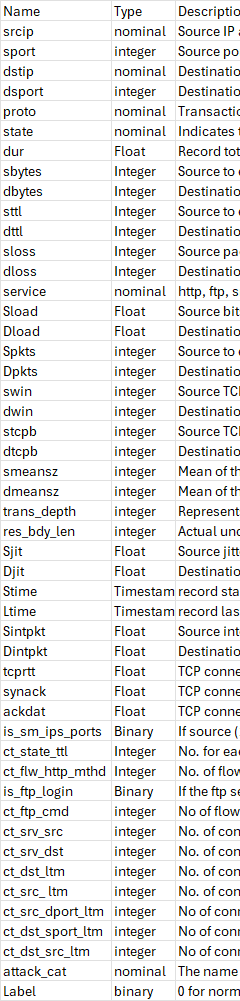

## 1.4 Class Distribution

I want to understand the distribution of the of the target feature in our dataset.

In [12]:
no_attack = df['attack_cat'].isnull().sum()
print((no_attack / len(df)) * 100)

87.35131568223615


In [13]:
df['attack_cat'].value_counts()

attack_cat
Generic             215481
Exploits             44505
 Fuzzers             19191
DoS                  16353
 Reconnaissance      12228
 Fuzzers              5051
Analysis              2677
Backdoor              1795
Reconnaissance        1759
 Shellcode            1288
Backdoors              534
Shellcode              223
Worms                  174
Name: count, dtype: int64

Before analyzing cardinality and class imbalance, we need to clean up some of those strings: there is leading/trailing whitespace for the "Fuzzers" and "Reconnaissance" categories, as well as singular/plural form issues for "Backdoor" and "Backdoors."

In [14]:
df['attack_cat'] = df['attack_cat'].str.strip().replace('Backdoors', 'Backdoor')

print("Cleaned attack_cat value counts:")
print(df['attack_cat'].value_counts())

Cleaned attack_cat value counts:
attack_cat
Generic           215481
Exploits           44505
Fuzzers            24242
DoS                16353
Reconnaissance     13987
Analysis            2677
Backdoor            2329
Shellcode           1511
Worms                174
Name: count, dtype: int64


In [15]:
print(df['attack_cat'].value_counts(normalize=True) * 100)

attack_cat
Generic           67.073919
Exploits          13.853308
Fuzzers            7.545936
DoS                5.090285
Reconnaissance     4.353808
Analysis           0.833284
Backdoor           0.724960
Shellcode          0.470337
Worms              0.054162
Name: proportion, dtype: float64


The dataset exhibits high class imbalance with 87.35% normal traffic and 12.65% attacks. For threat classification, attack categories show high imbalance with "Generic" attacks dominating at 67% of all attacks while rare classes like Shellcode represent less than 1%.

# Part 2: Exploratory Data Analysis

## 2.1 Missing Values

In [16]:
missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
})

missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(missing_summary)

                  Missing_Count  Missing_Percentage
attack_cat              2218602           87.351316
ct_ftp_cmd              1429879           56.297530
ct_flw_http_mthd        1347959           53.072156
dsport                      304            0.011969
sport                         8            0.000315


We aren't concerned about missing values in the attack_cat column since it is only missing for normal traffic.

The missing values for ct_ftp_cmd and ct_flw_http_mthd are likely due to the fact that these features only apply to FTP and HTTP traffic, respectively. Since the majority of the traffic in the dataset is normal, it makes sense that these features would be missing for many records.

The missing values in the sport and dsport columns are more worrisome, as they are important features for network traffic analysis. Because the source and destination ports would be an important, intentional feature of any attack, we will drop any records with missing values in these columns.

In [17]:
print(f"Rows before dropping: {len(df)}")

df = df.dropna(subset=['sport', 'dsport'])

print(f"Rows after dropping: {len(df)}")
print(f"Rows dropped: {2539861 - len(df)}")

Rows before dropping: 2539861
Rows after dropping: 2539553
Rows dropped: 308


## 2.2 Numeric Feature Analysis

In [18]:
numeric_features = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
                   'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb',
                   'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
                   'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
                   'ackdat', 'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd',
                   'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm',
                   'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']

categorical_features = ['proto', 'state', 'service', 'is_sm_ips_ports', 'is_ftp_login']

# for categorical features we skil 'srcip', 'sport', 'dstip', 'dsport', because they are very high cardinality and not useful for EDA

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


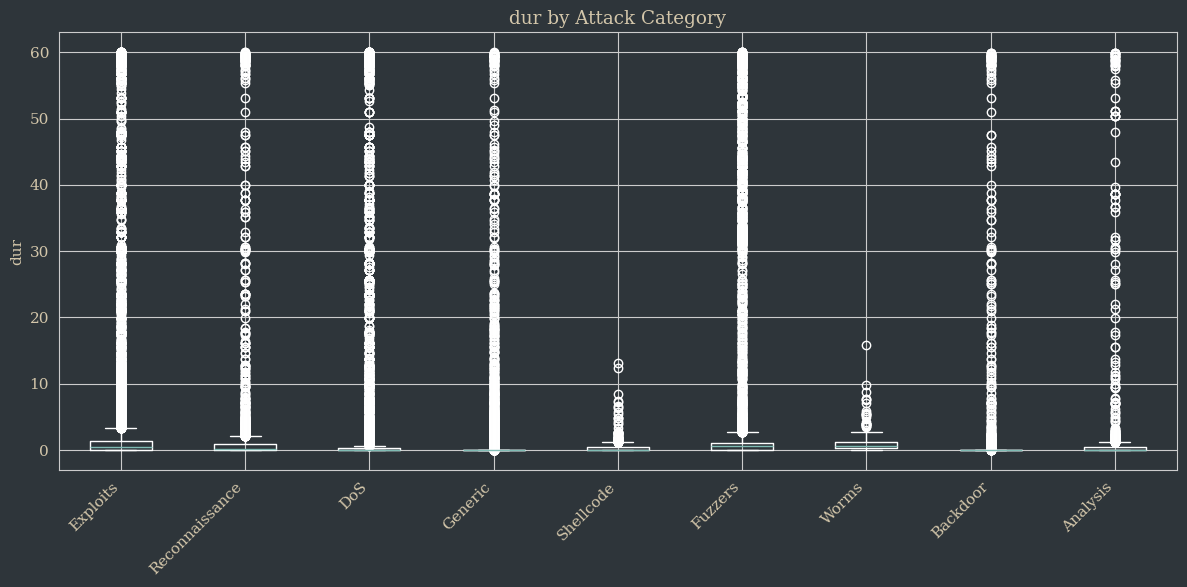

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


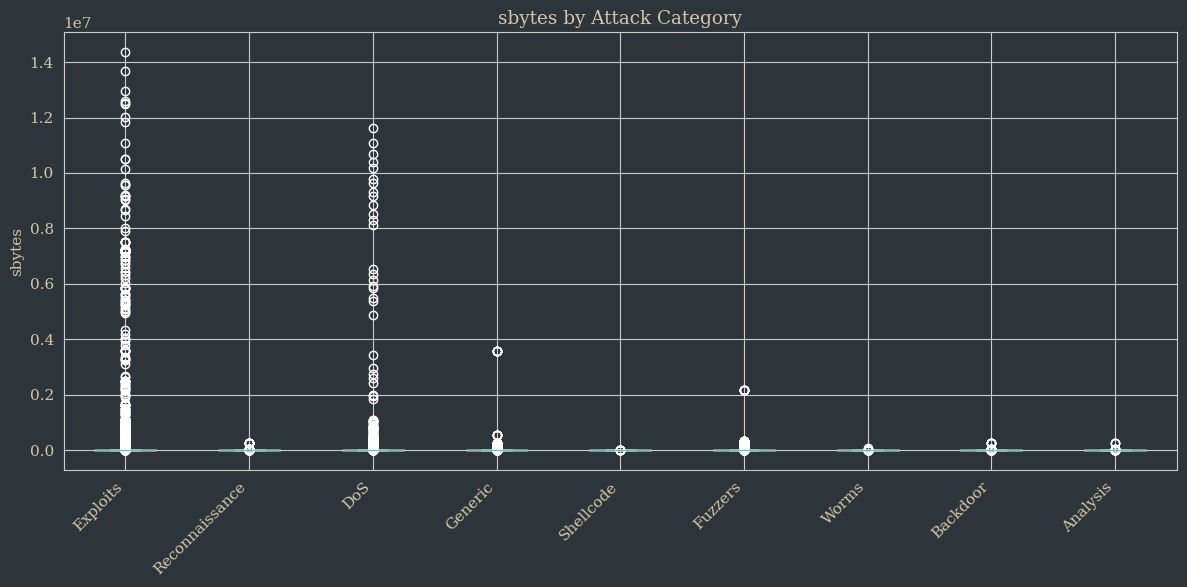

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


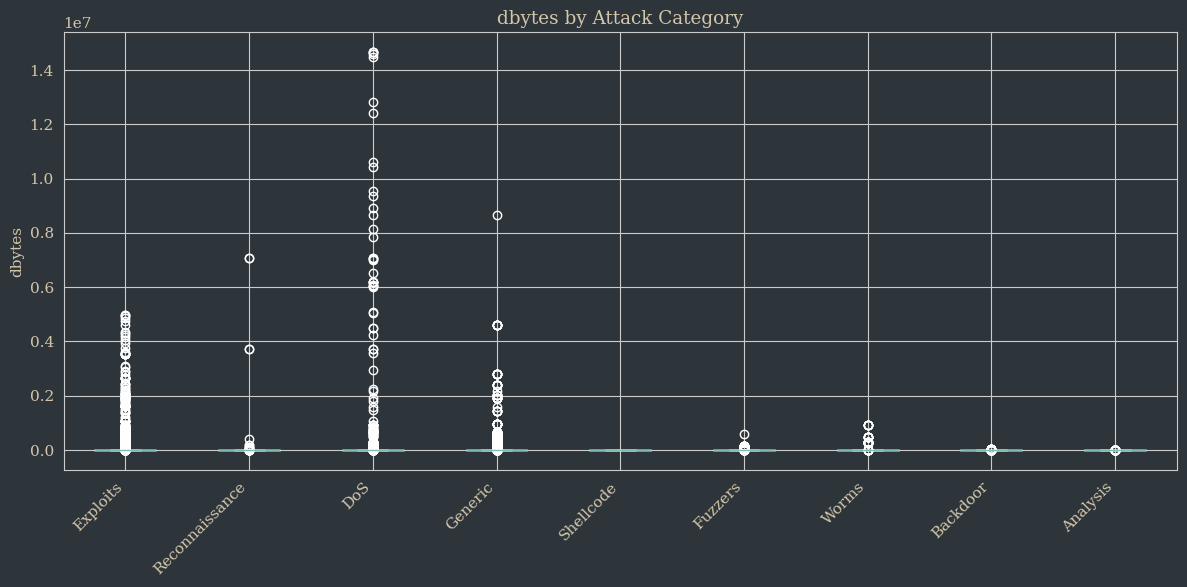

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


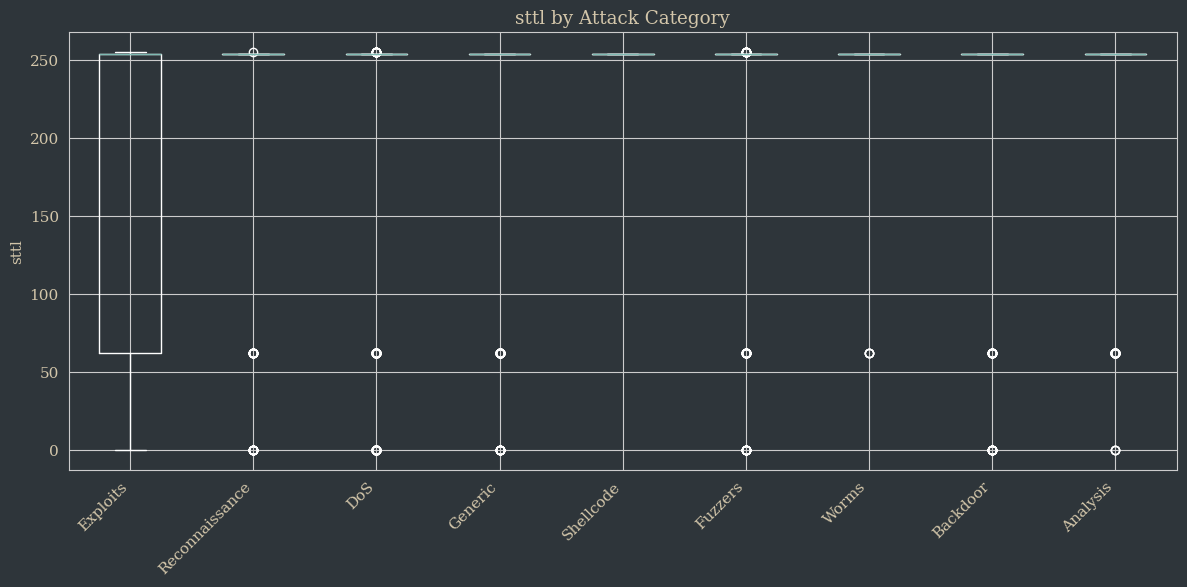

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


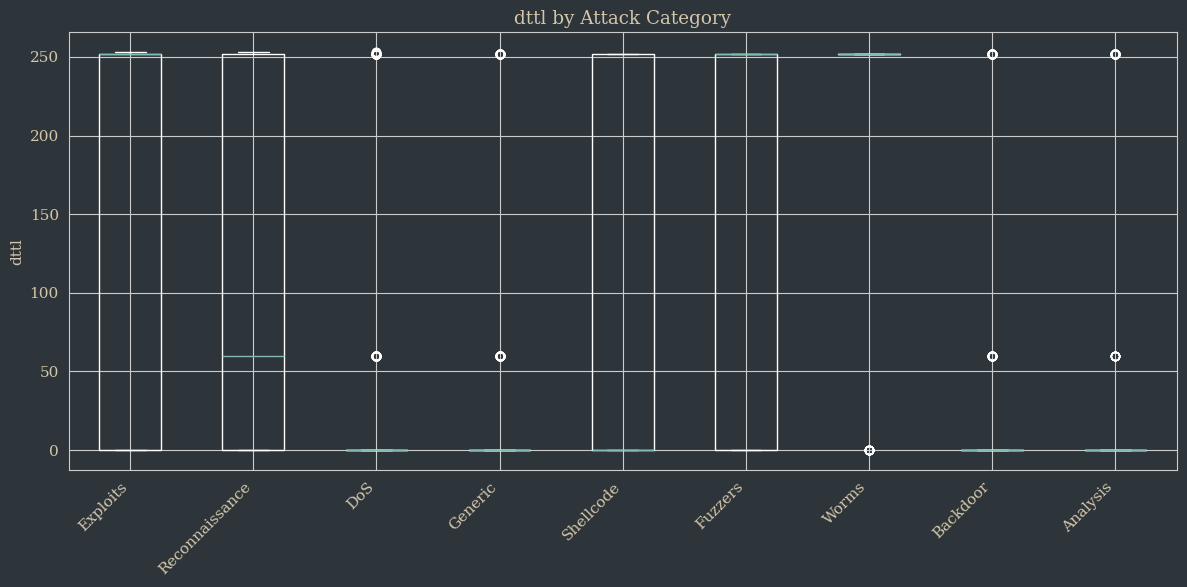

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


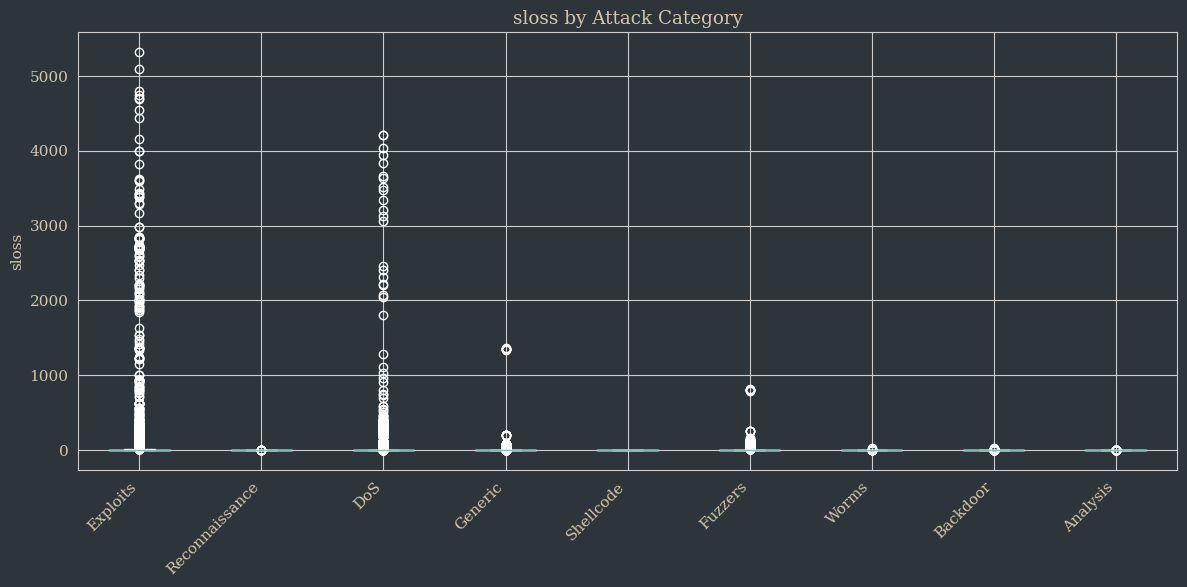

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


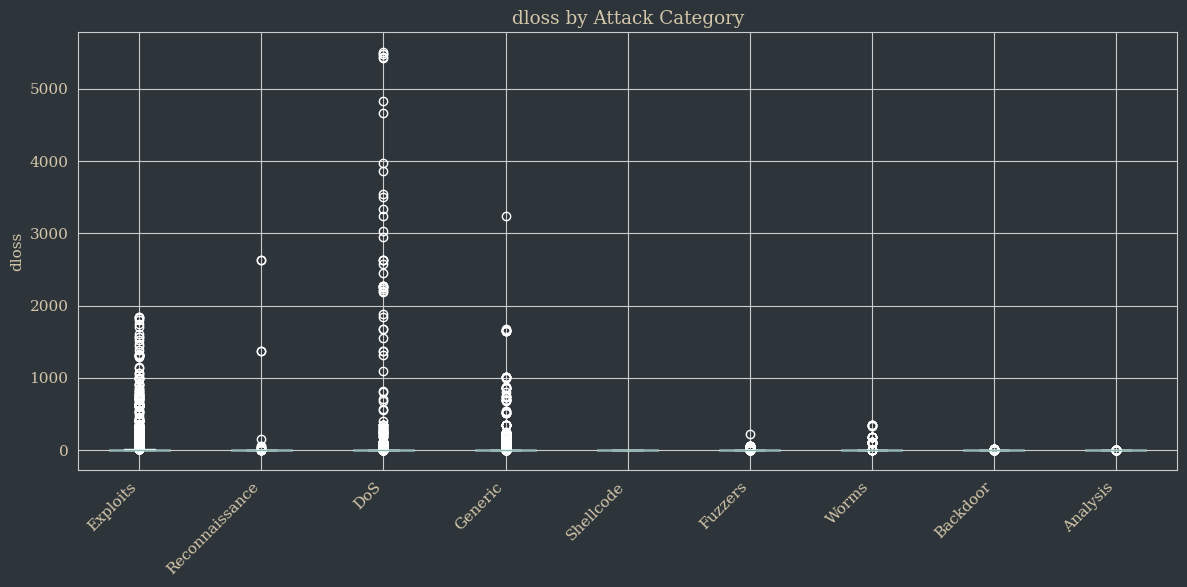

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


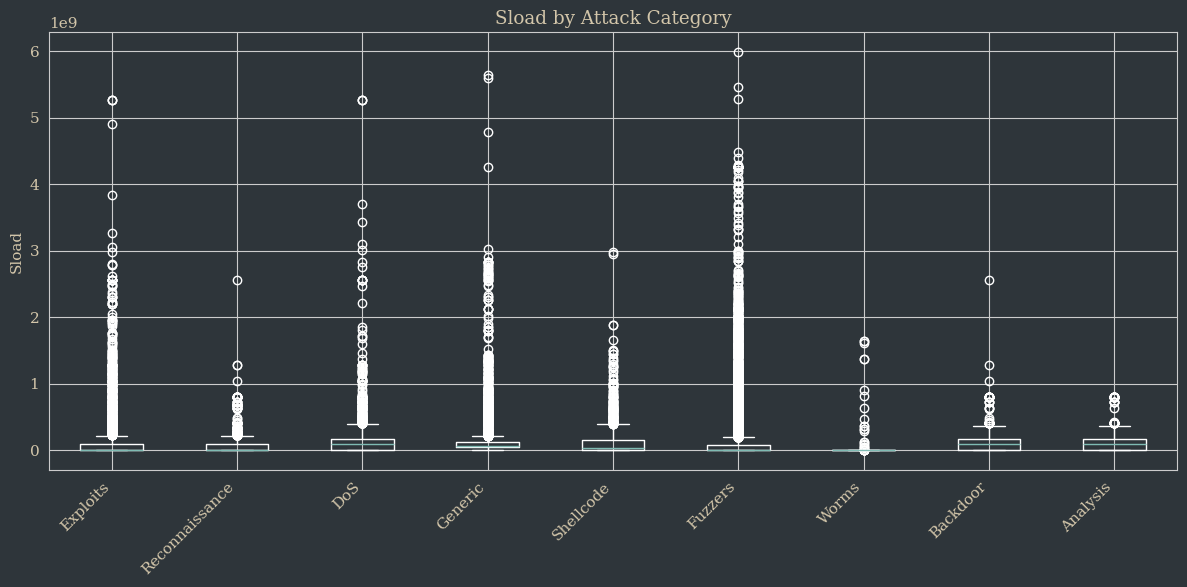

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


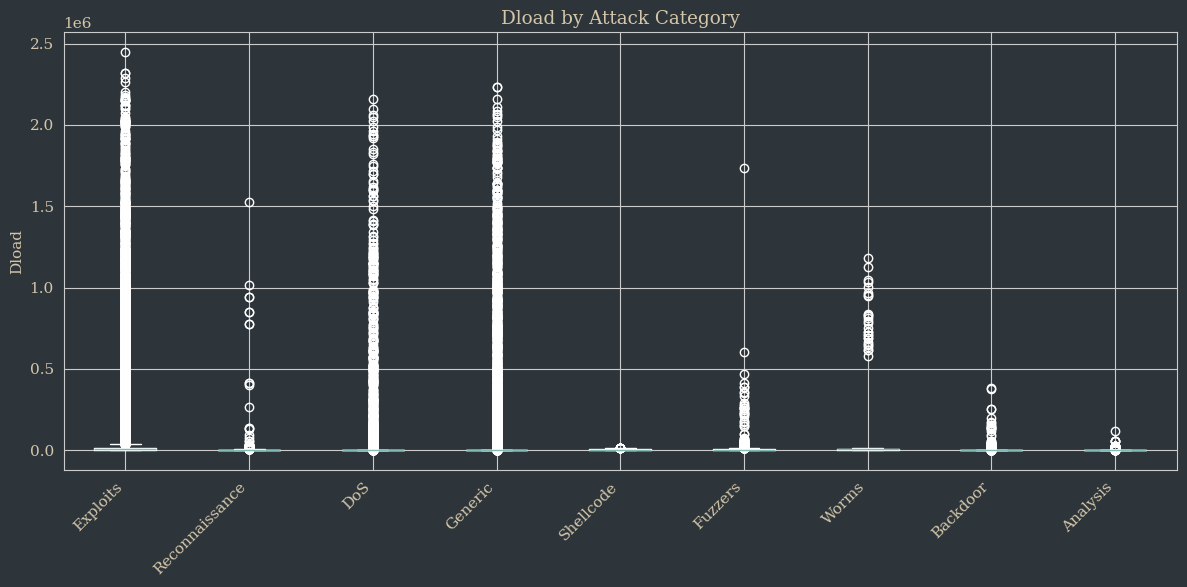

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


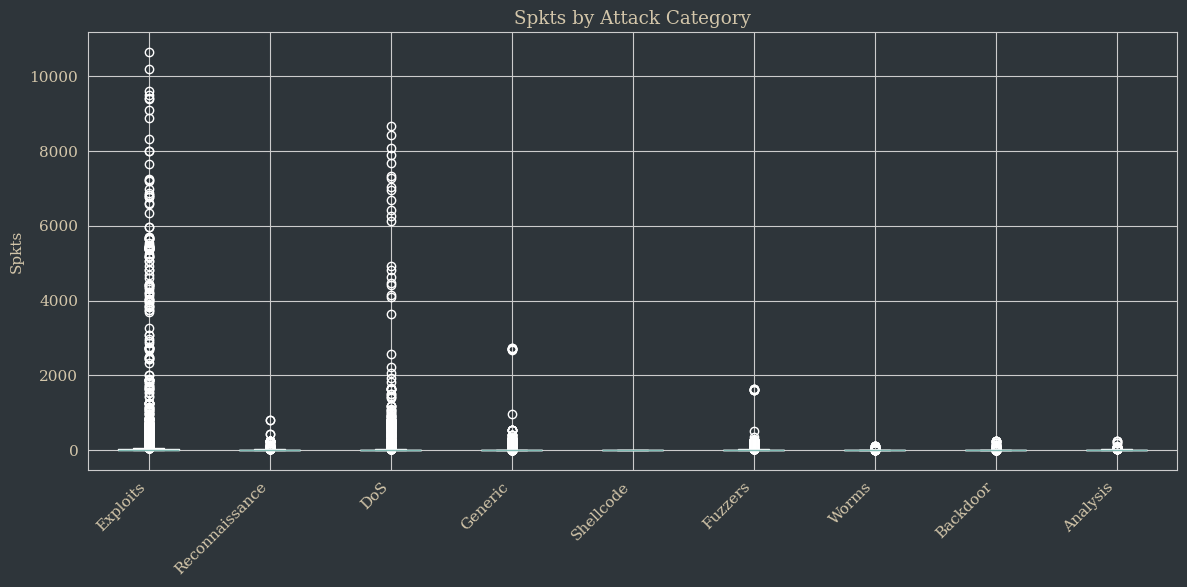

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


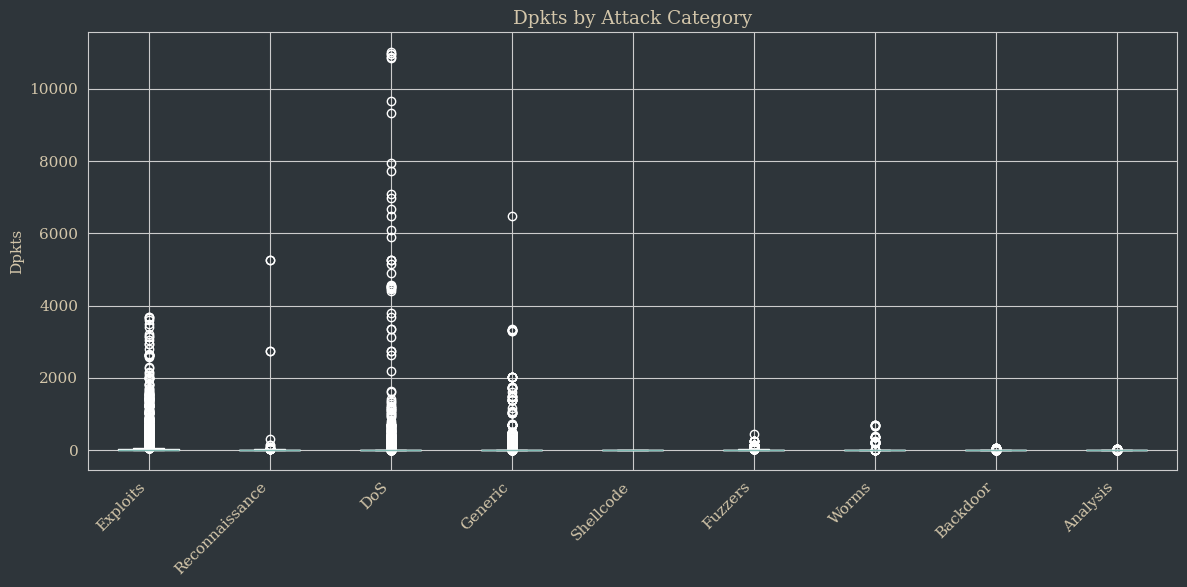

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


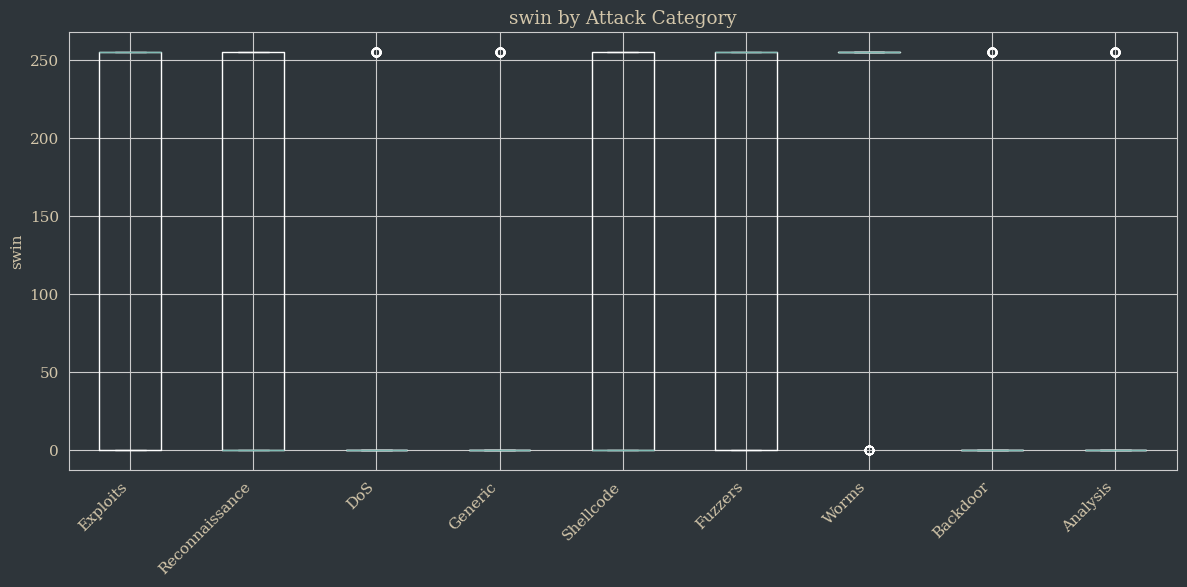

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


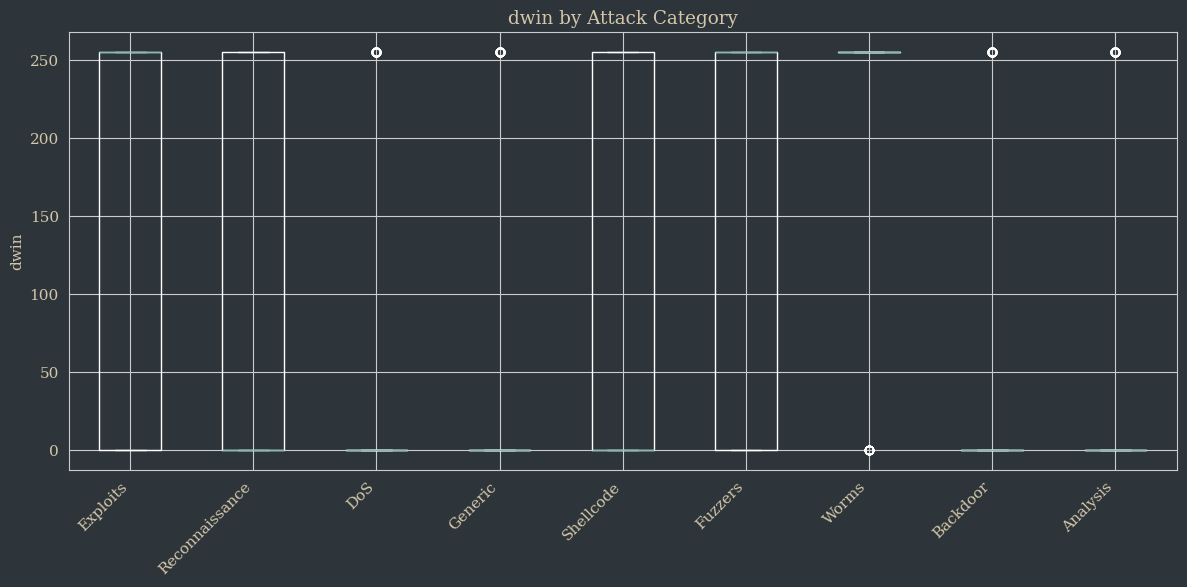

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


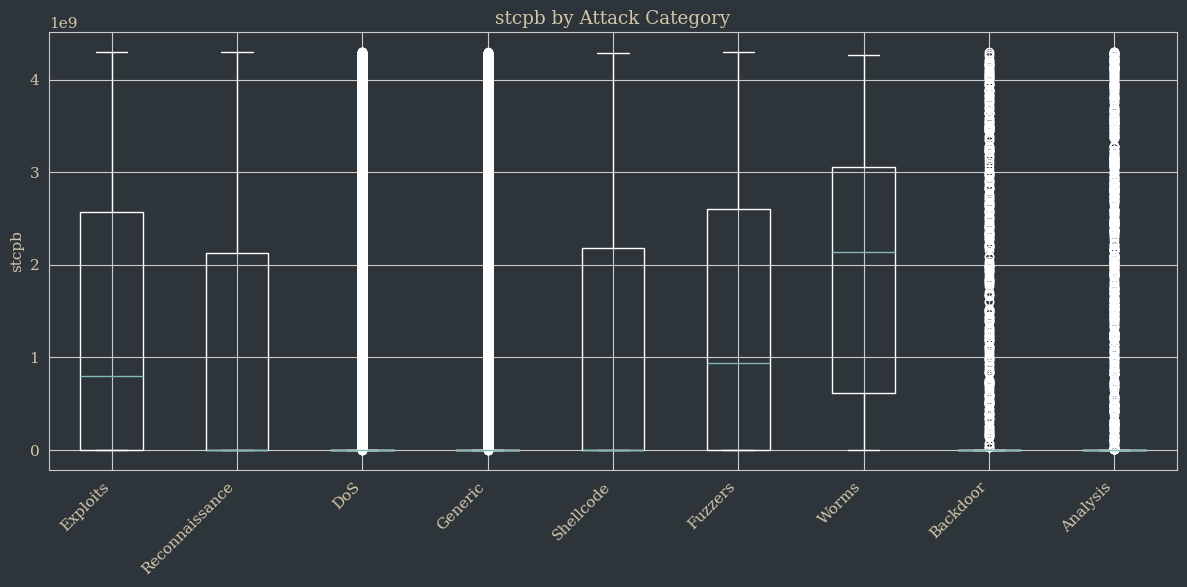

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


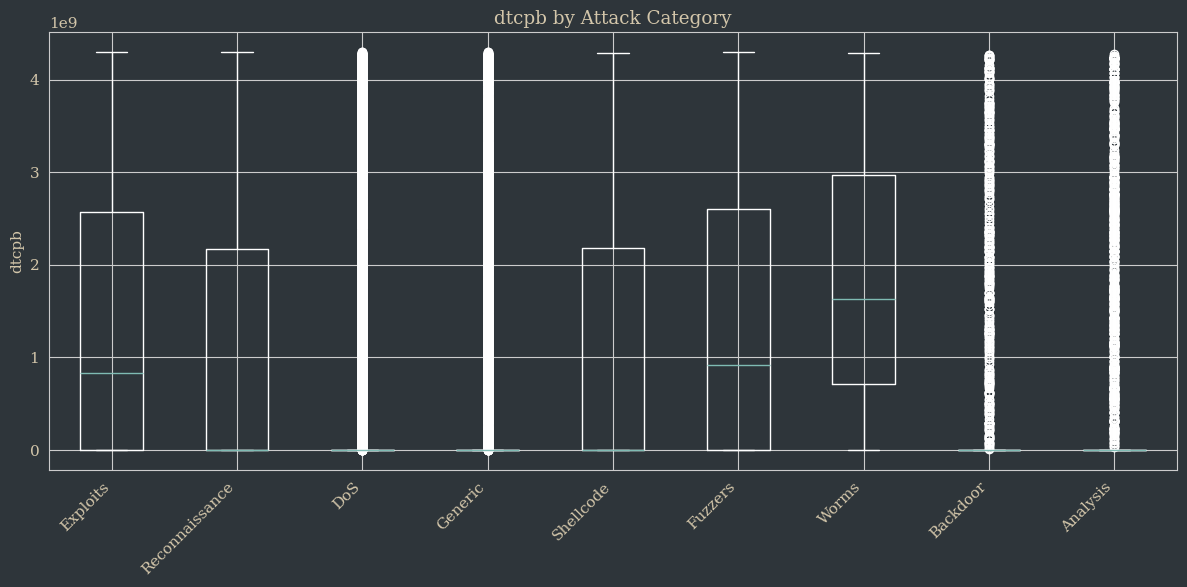

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


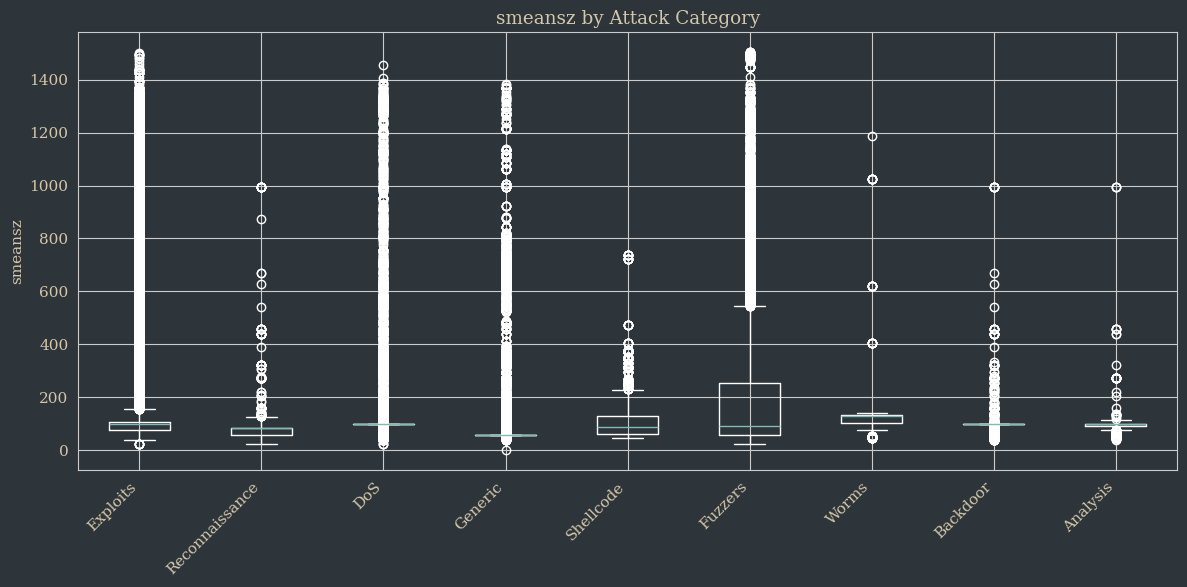

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


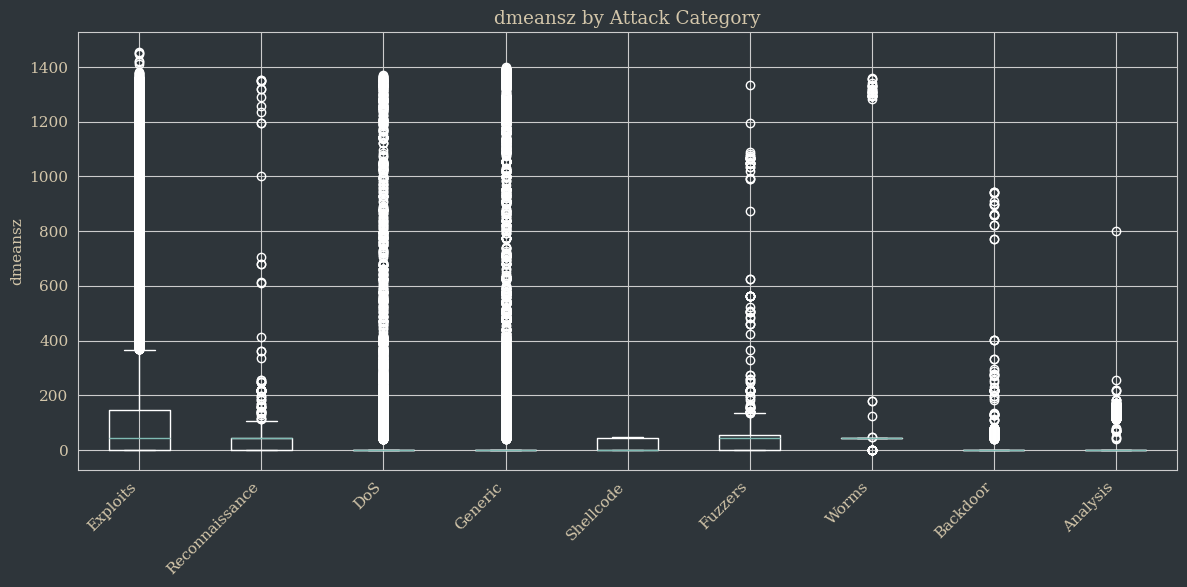

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


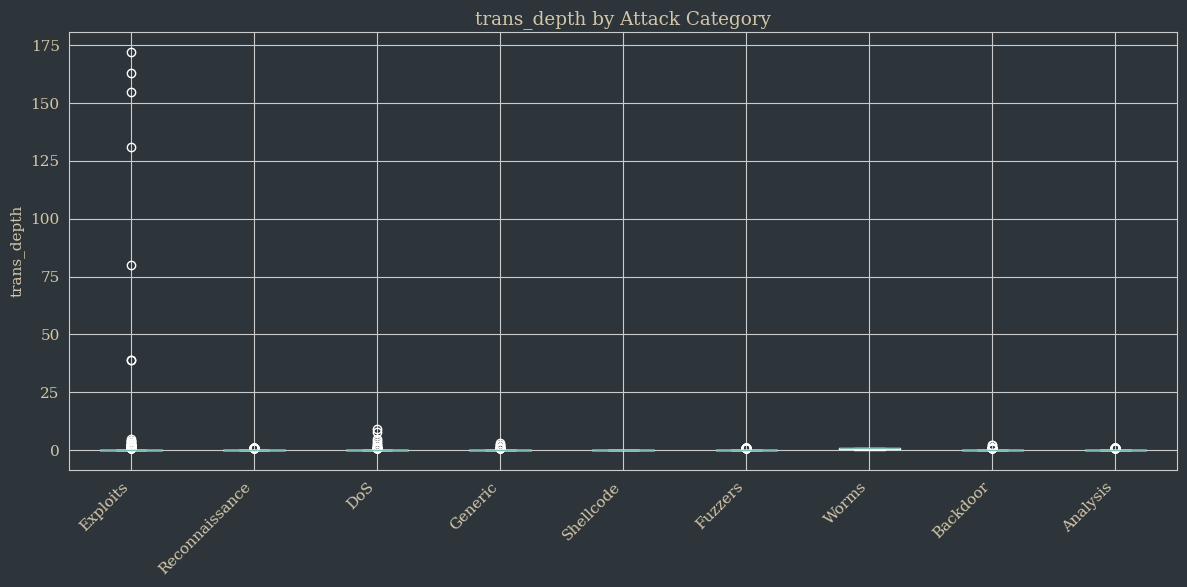

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


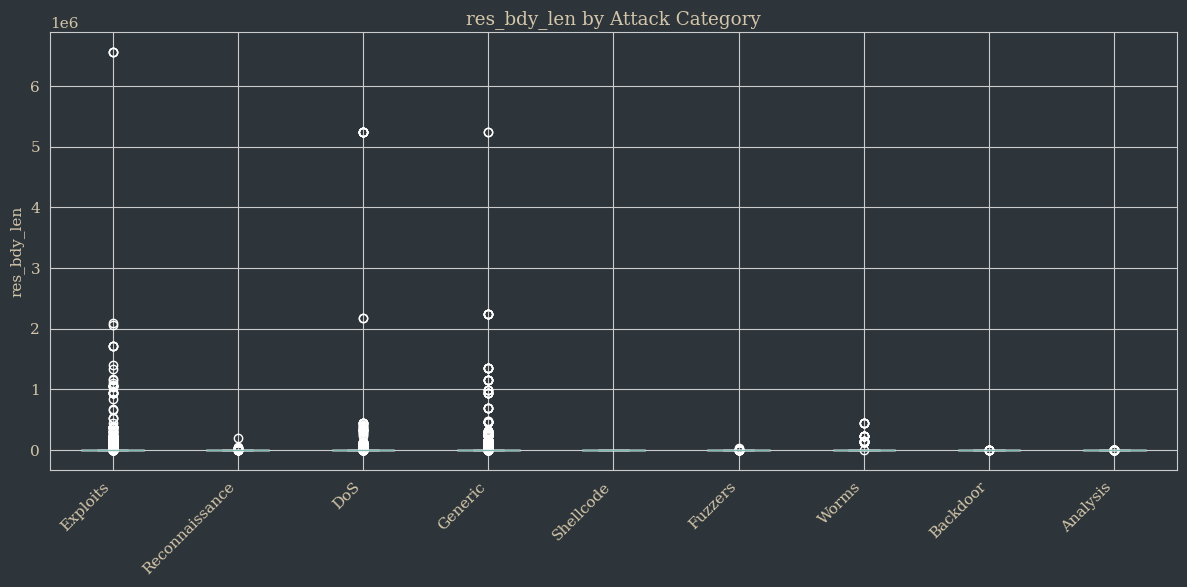

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


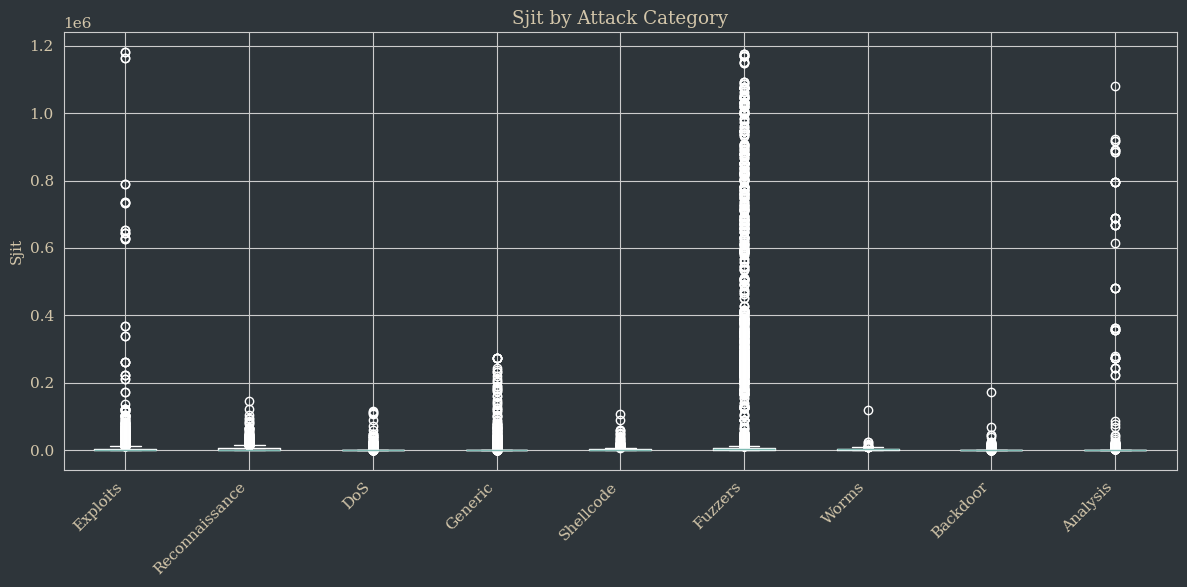

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


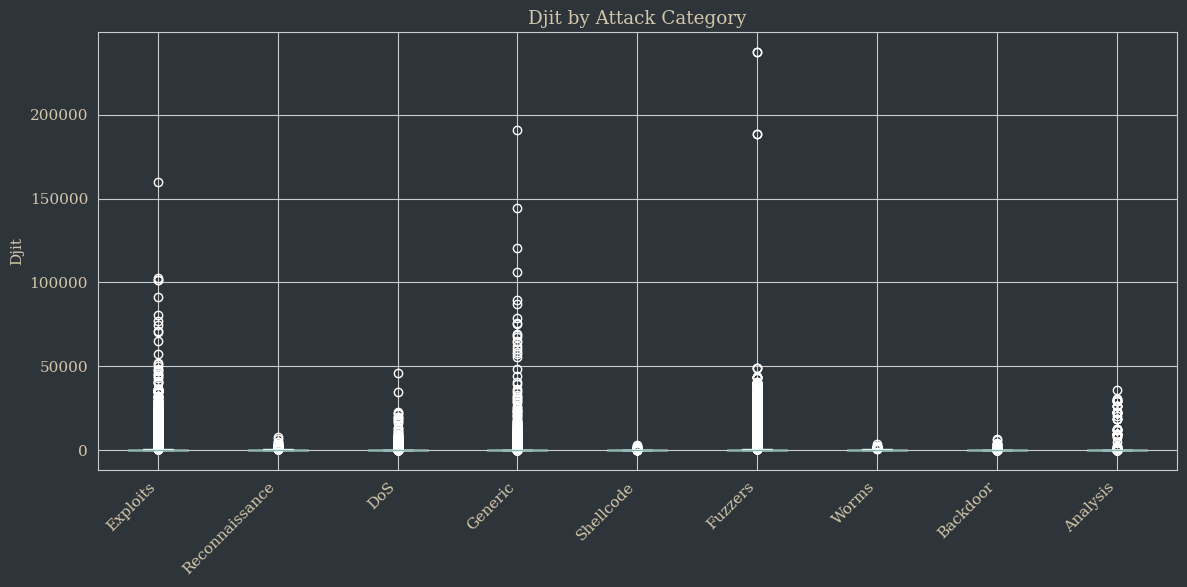

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


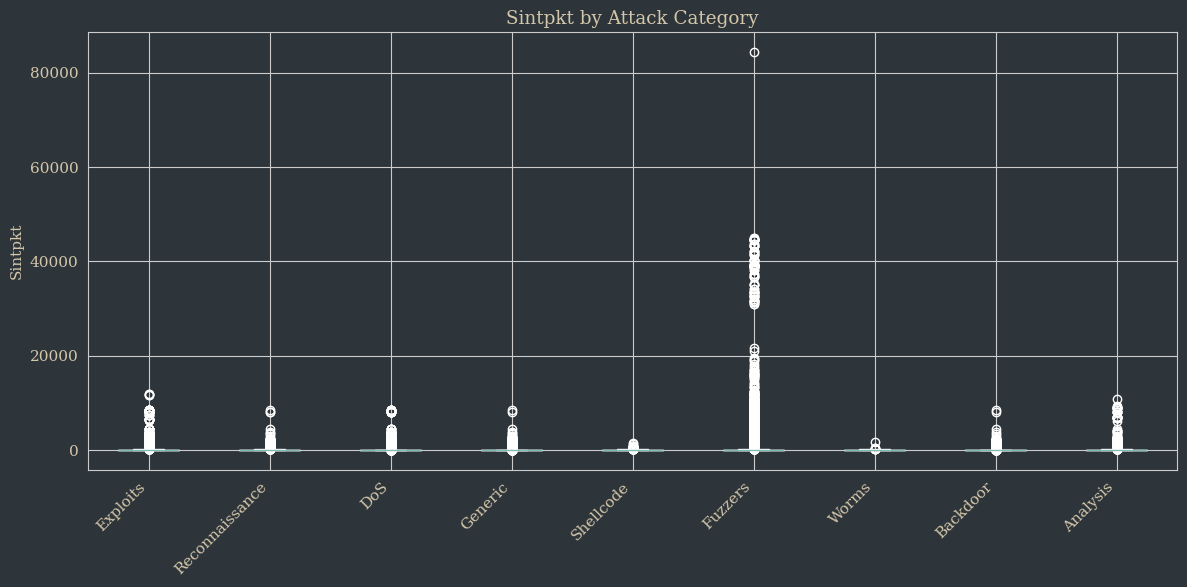

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


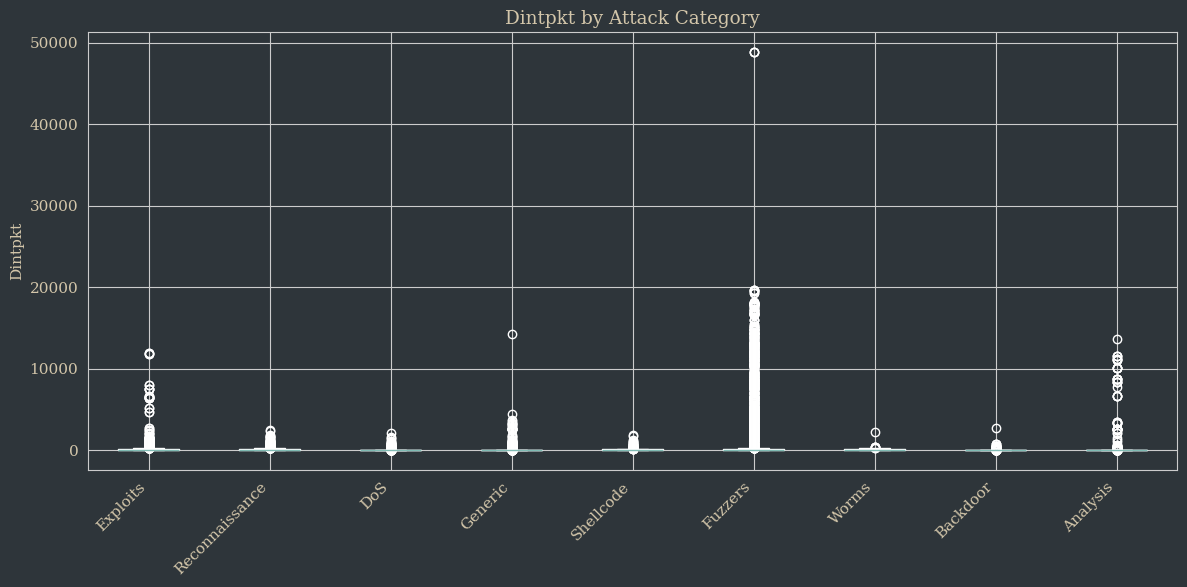

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


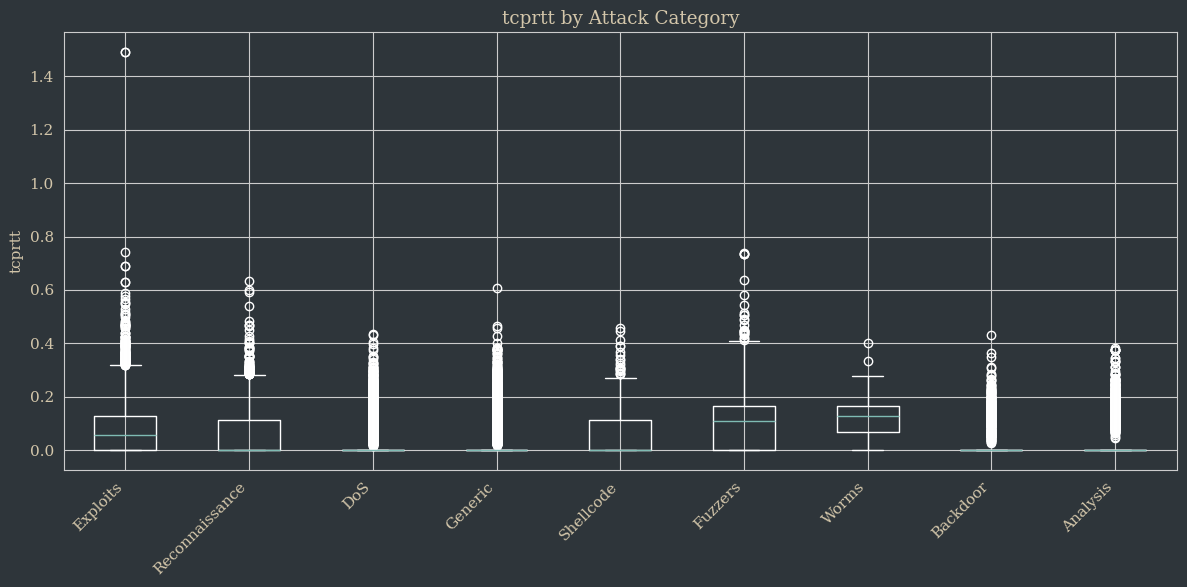

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


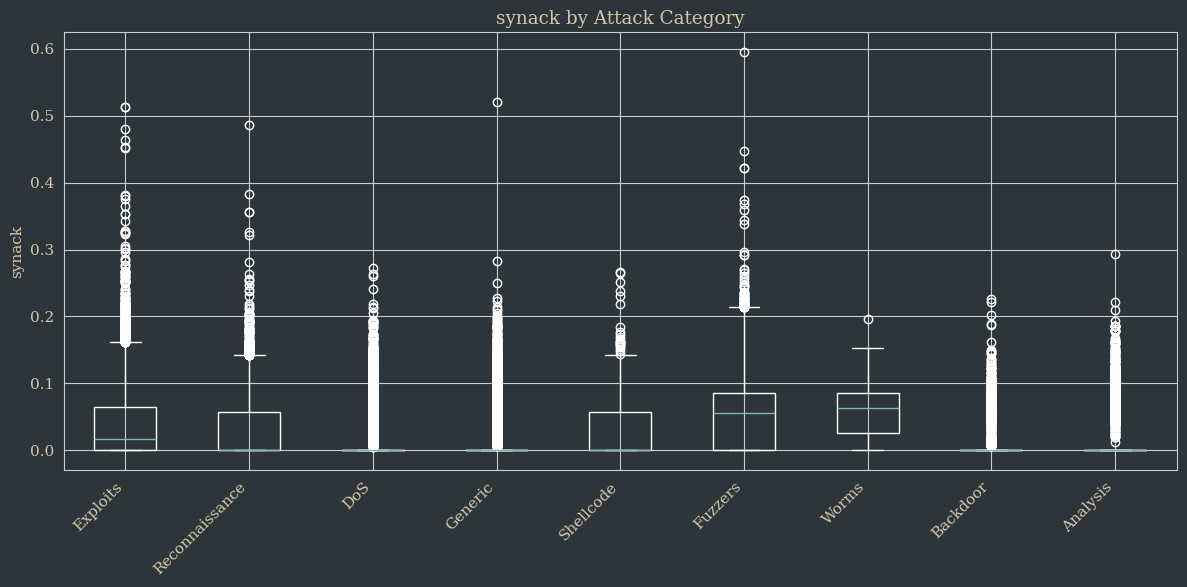

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


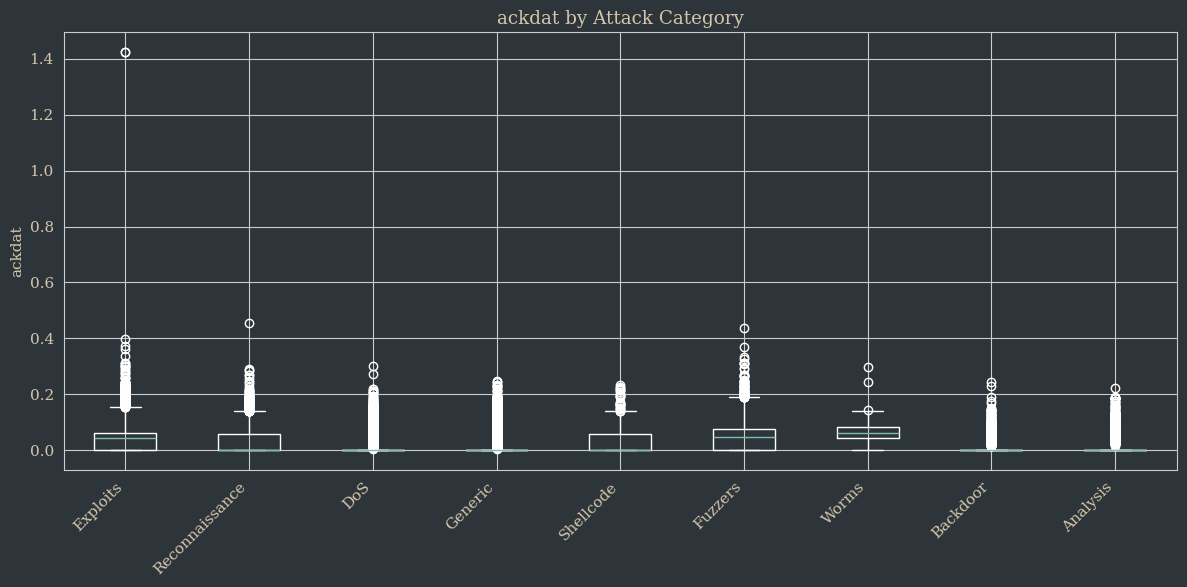

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


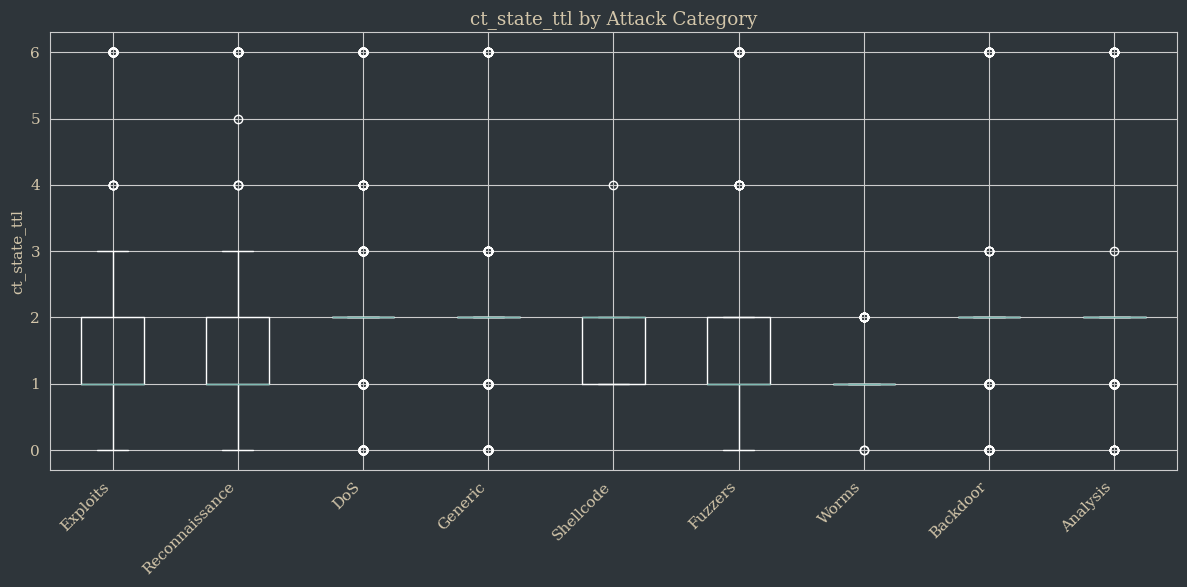

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


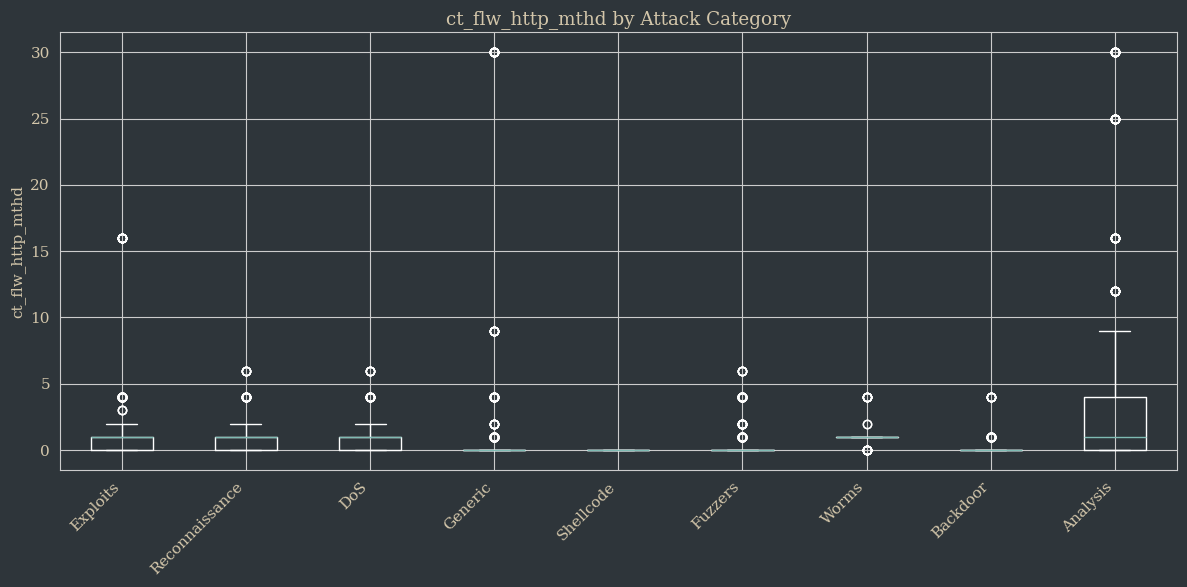

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


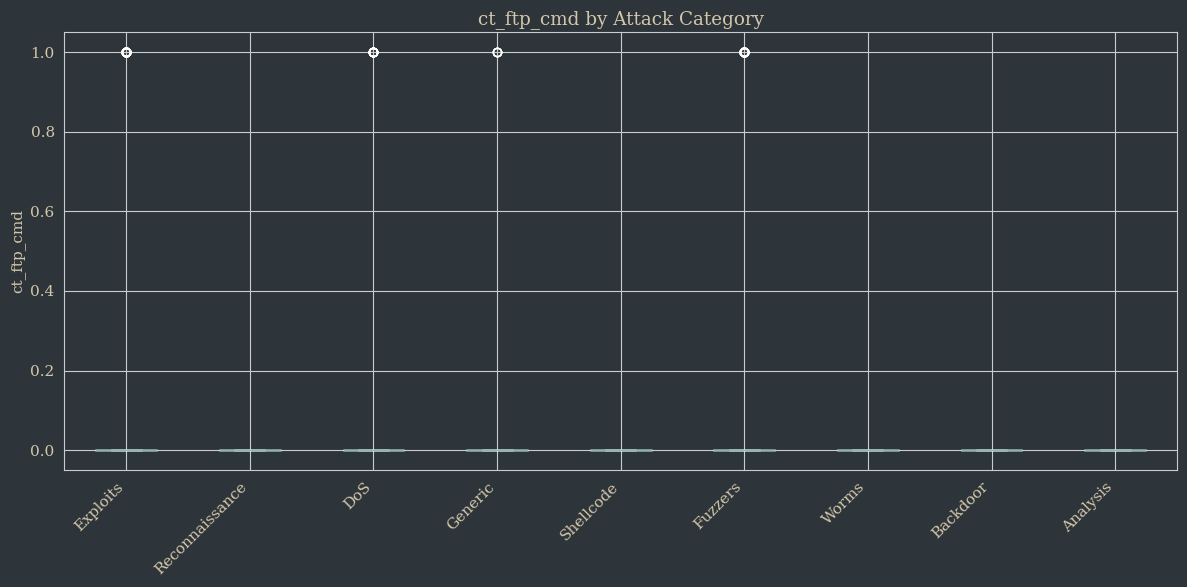

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


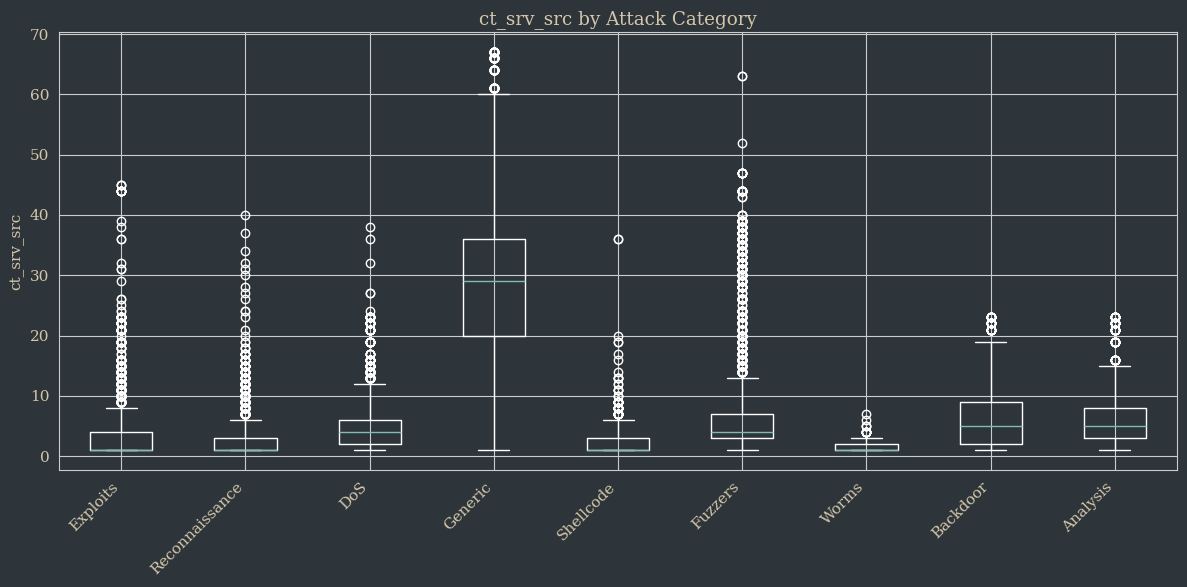

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


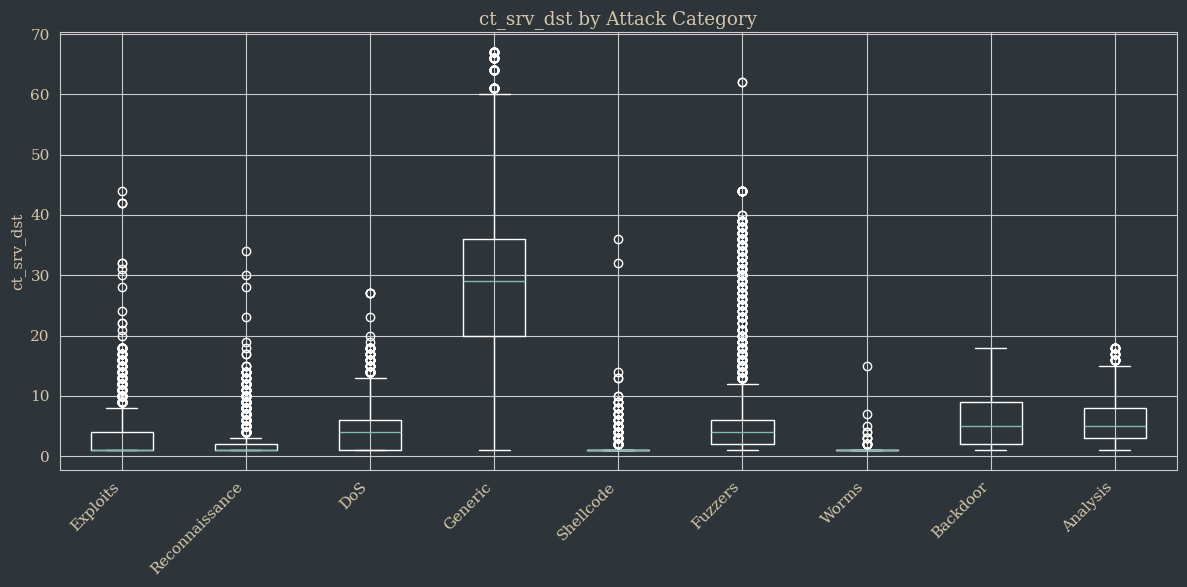

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


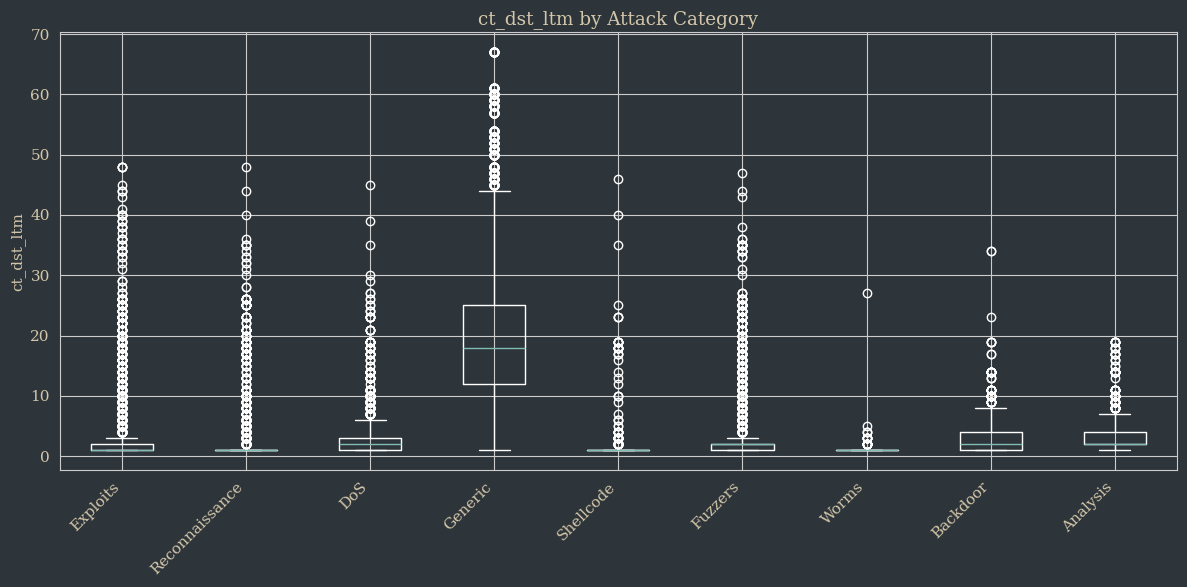

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


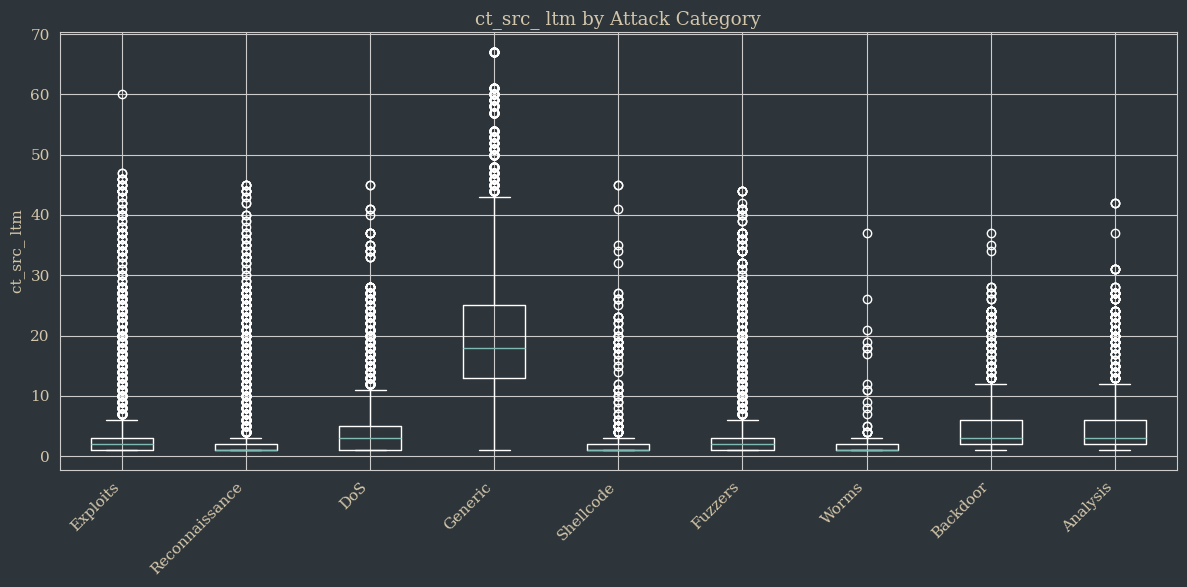

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


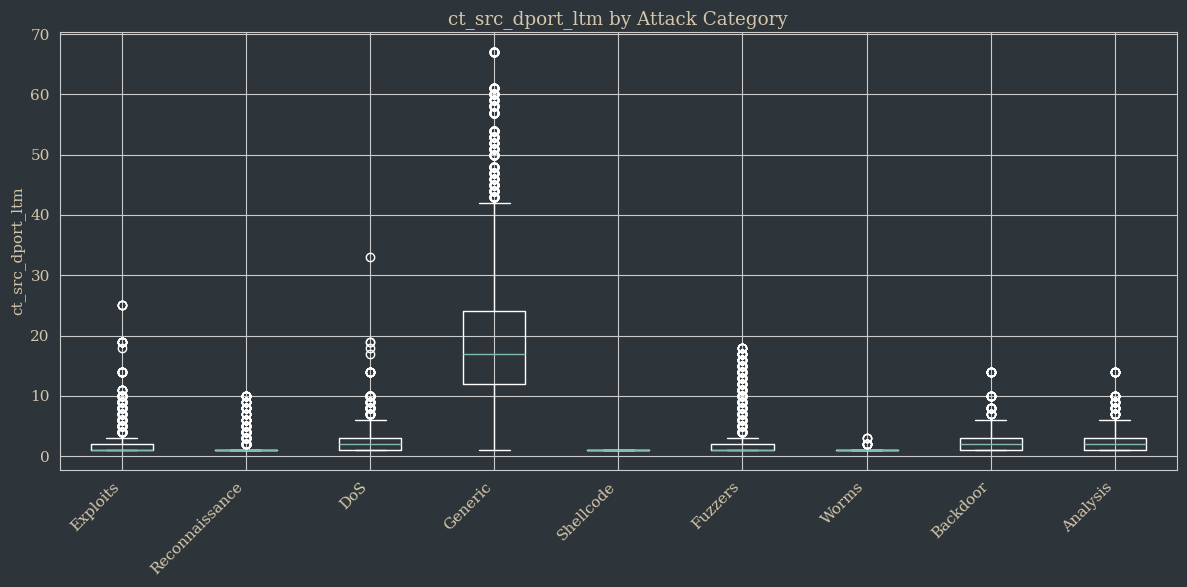

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


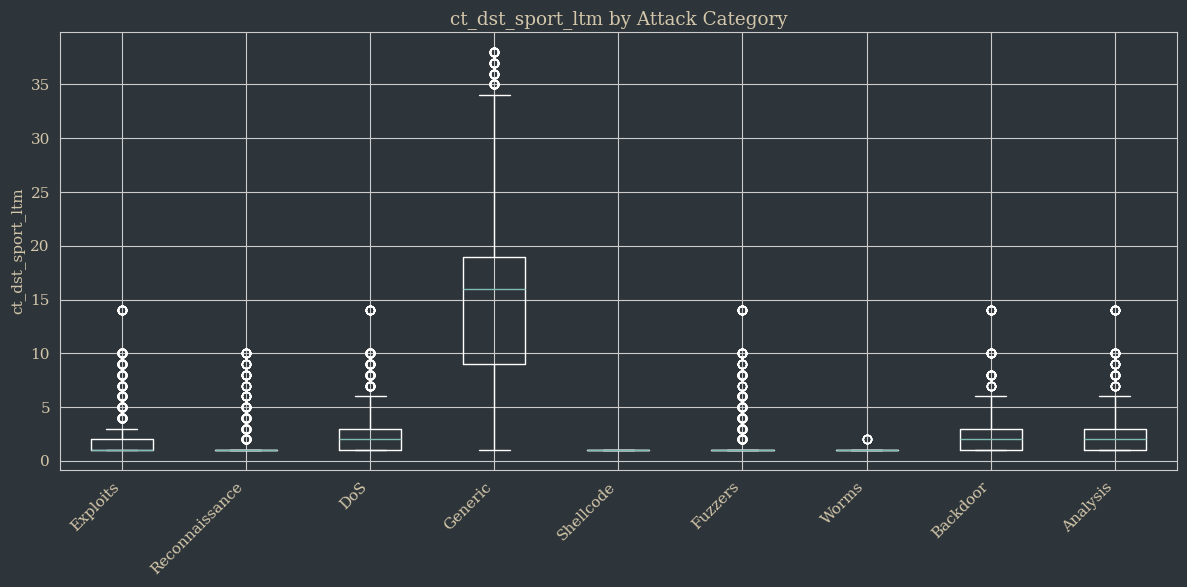

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\2784354580.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


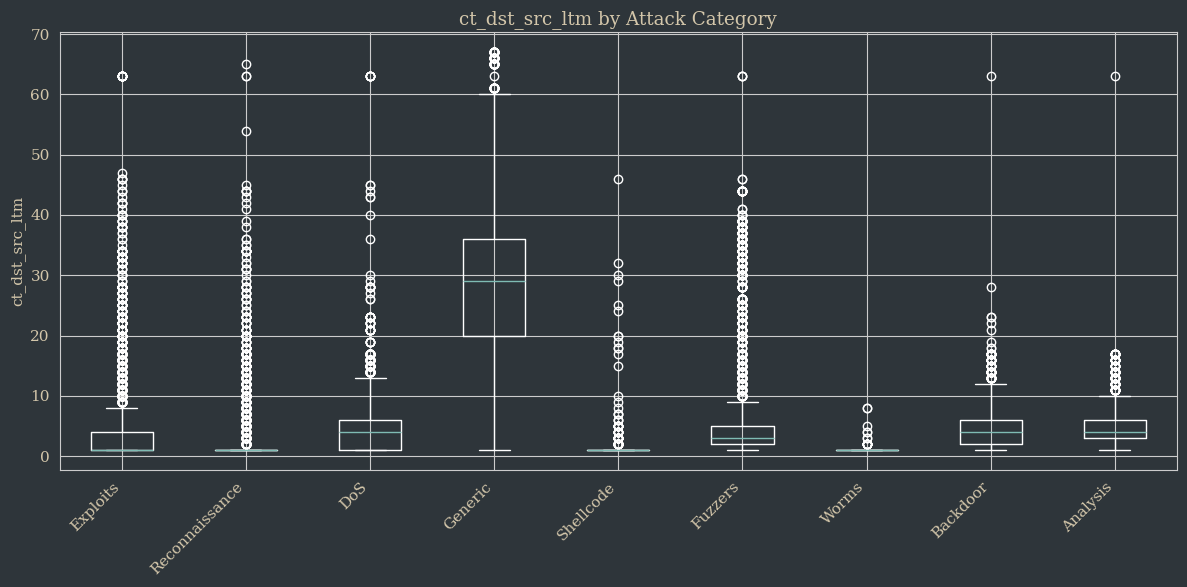

In [19]:
attack_types = df['attack_cat'].dropna().unique()

for feature in numeric_features:
    plt.figure(figsize=(12, 6))

    data_to_plot = [df[df['attack_cat'] == attack][feature].dropna() for attack in attack_types]

    plt.boxplot(data_to_plot, labels=attack_types)
    plt.title(f'{feature} by Attack Category')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\3399704240.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


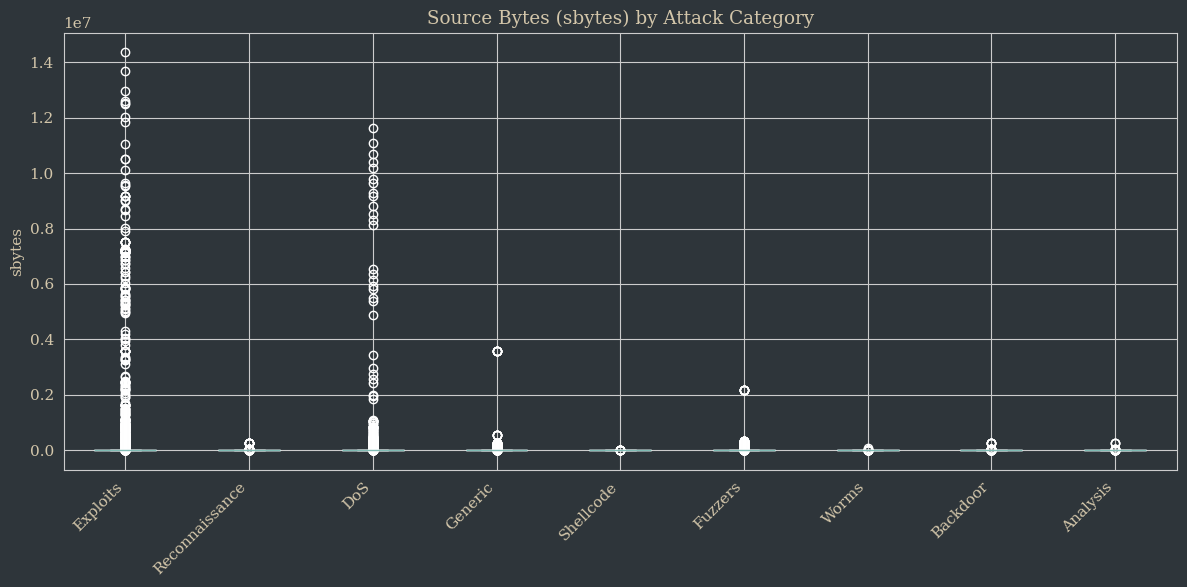

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\3399704240.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


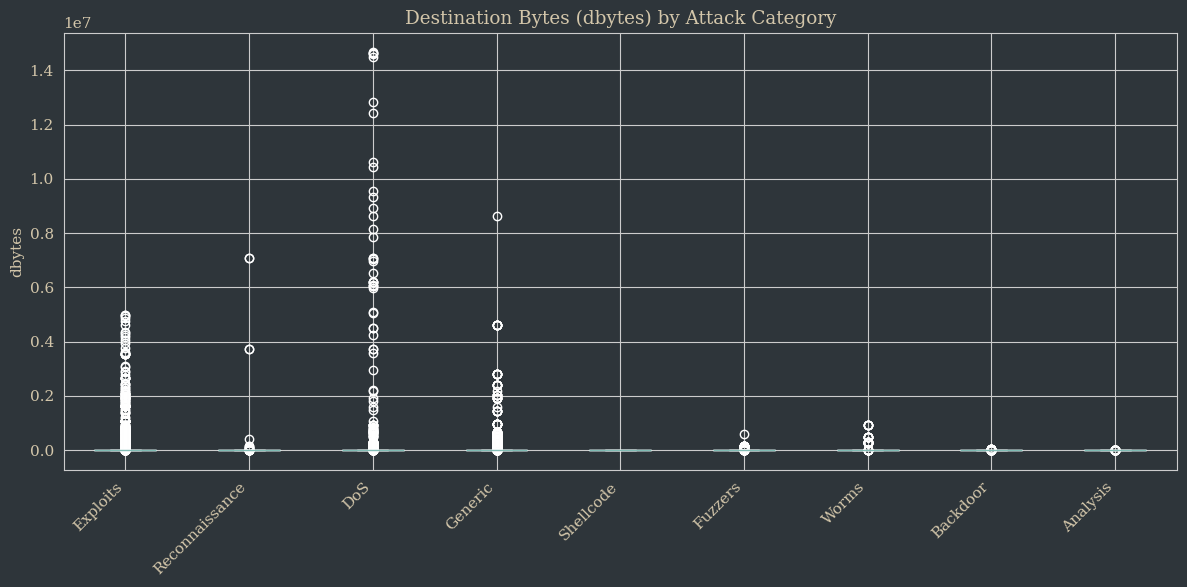

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\3399704240.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


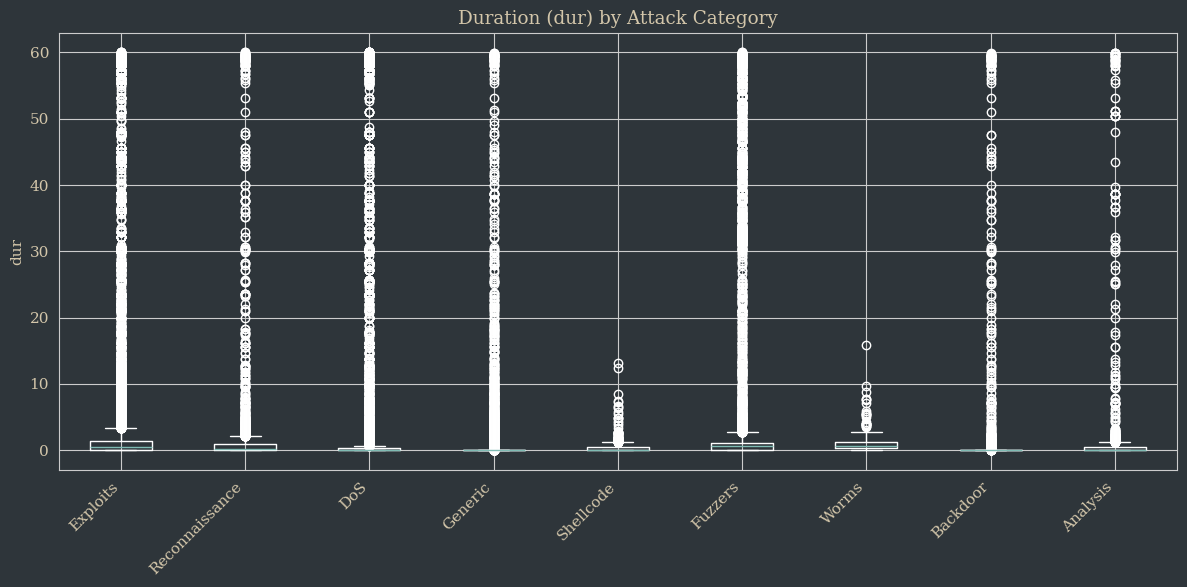

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\3399704240.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


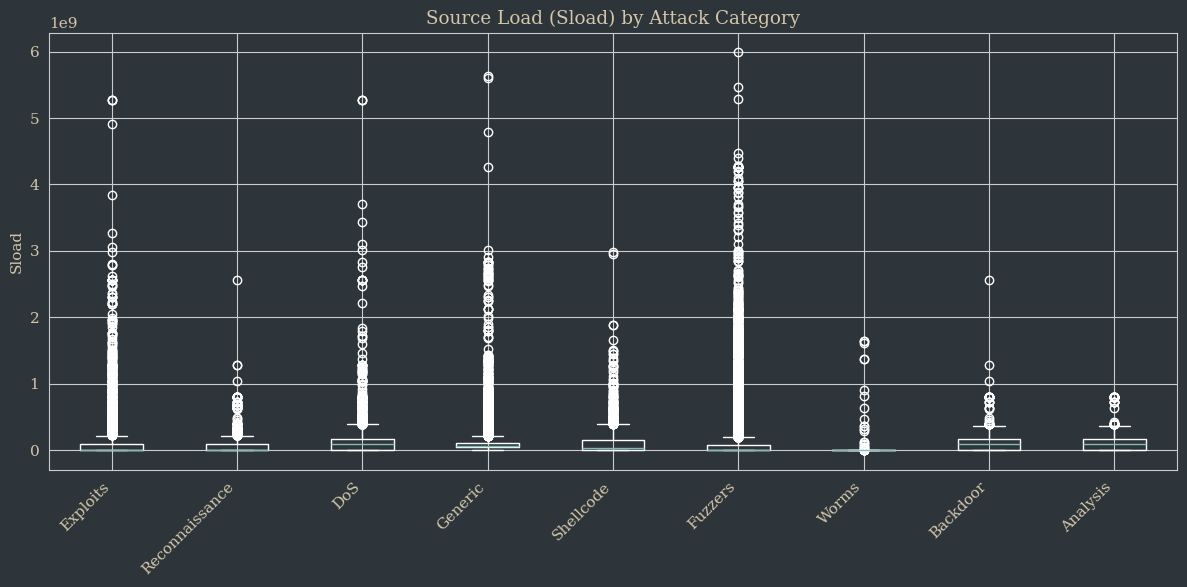

C:\Users\Eric\AppData\Local\Temp\ipykernel_50572\3399704240.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=attack_types)


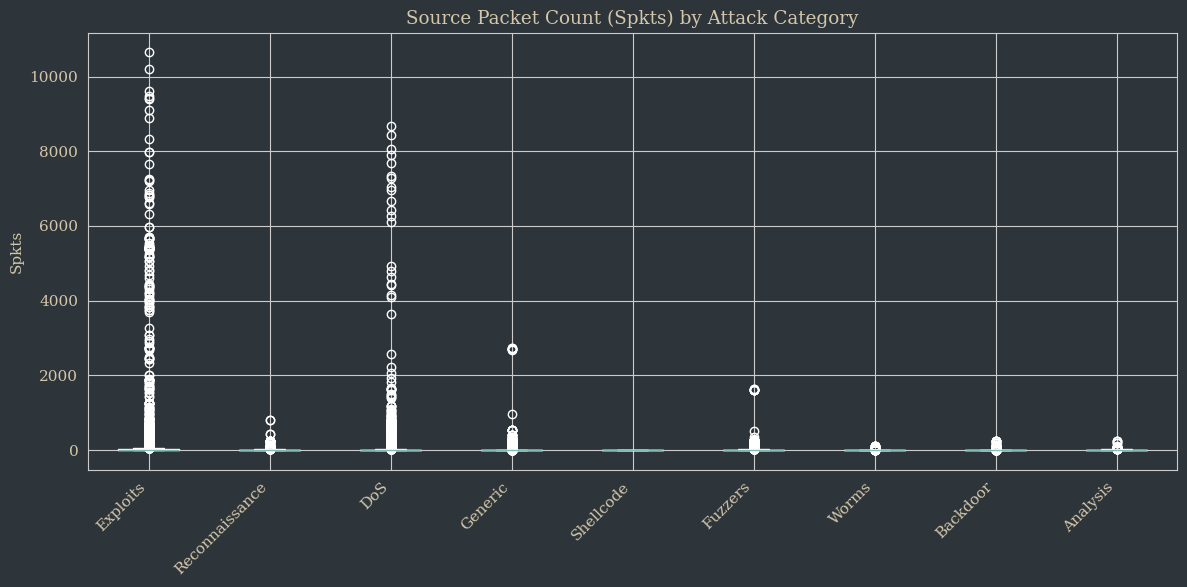

In [20]:
attack_types = df['attack_cat'].dropna().unique()

plt.figure(figsize=(12, 6))
data_to_plot = [df[df['attack_cat'] == attack]['sbytes'].dropna() for attack in attack_types]
plt.boxplot(data_to_plot, labels=attack_types)
plt.title('Source Bytes (sbytes) by Attack Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('sbytes')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
data_to_plot = [df[df['attack_cat'] == attack]['dbytes'].dropna() for attack in attack_types]
plt.boxplot(data_to_plot, labels=attack_types)
plt.title('Destination Bytes (dbytes) by Attack Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('dbytes')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
data_to_plot = [df[df['attack_cat'] == attack]['dur'].dropna() for attack in attack_types]
plt.boxplot(data_to_plot, labels=attack_types)
plt.title('Duration (dur) by Attack Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('dur')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
data_to_plot = [df[df['attack_cat'] == attack]['Sload'].dropna() for attack in attack_types]
plt.boxplot(data_to_plot, labels=attack_types)
plt.title('Source Load (Sload) by Attack Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Sload')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
data_to_plot = [df[df['attack_cat'] == attack]['Spkts'].dropna() for attack in attack_types]
plt.boxplot(data_to_plot, labels=attack_types)
plt.title('Source Packet Count (Spkts) by Attack Category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Spkts')
plt.tight_layout()
plt.show()

### Numeric Feature Summary

1. **Source Bytes (sbytes)**: Exploits and DoS show significantly higher values, suggesting large data uploads or exfiltration.

2. **Destination Bytes (dbytes)**: DoS dominates with highest destination bytes, indicating substantial bidirectional communication.

3. **Duration (dur)**: Most attacks are very brief with many outliers; Shellcode shows particularly short durations.

4. **Source Load (Sload)**: Fuzzers show extreme outliers consistent with rapid-fire testing; DoS also exhibits high bandwidth usage.

5. **Source Packet Count (Spkts)**: Exploits and DoS have the highest packet counts, correlating with their high byte counts.

In general, volume-based features clearly distinguish heavy attacks (Exploits, DoS, Fuzzers) from lighter attacks (Worms, Backdoor, Analysis).

## 2.3 Categorical Feature Analysis

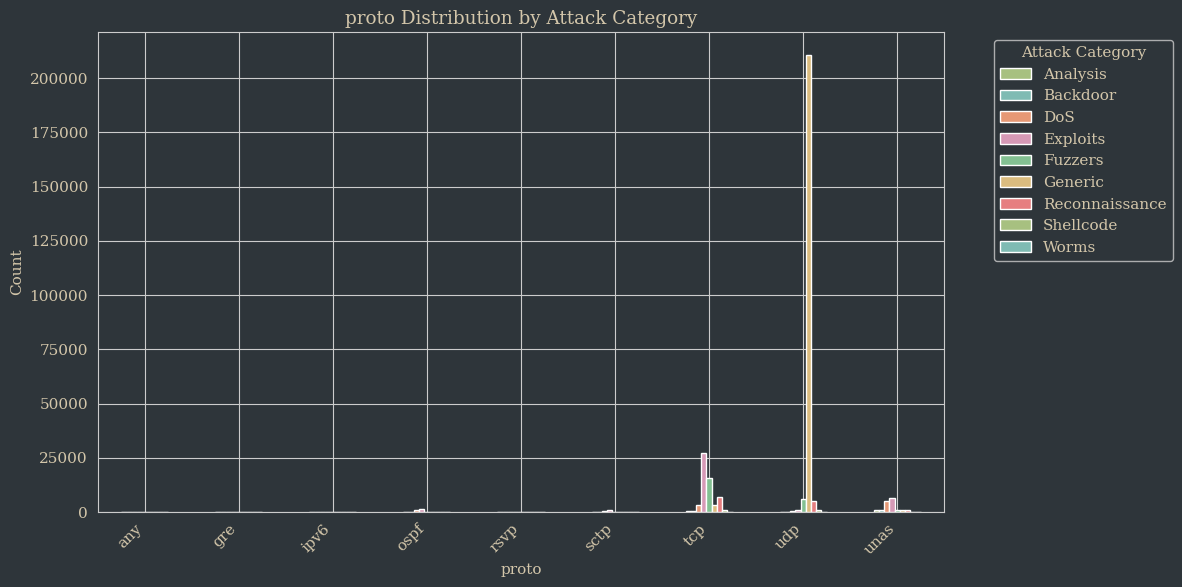

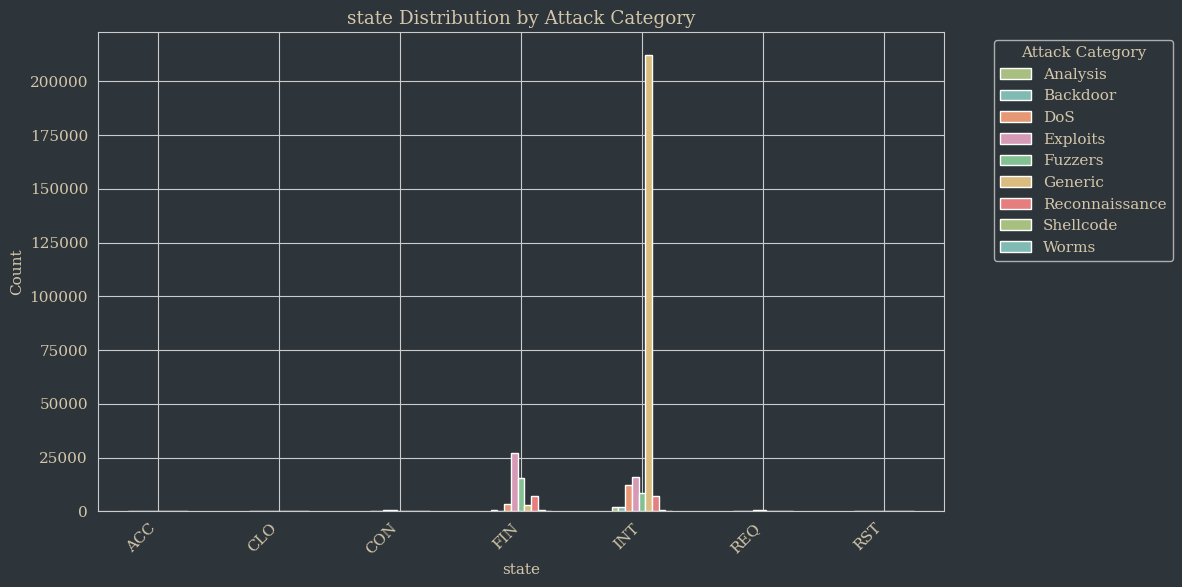

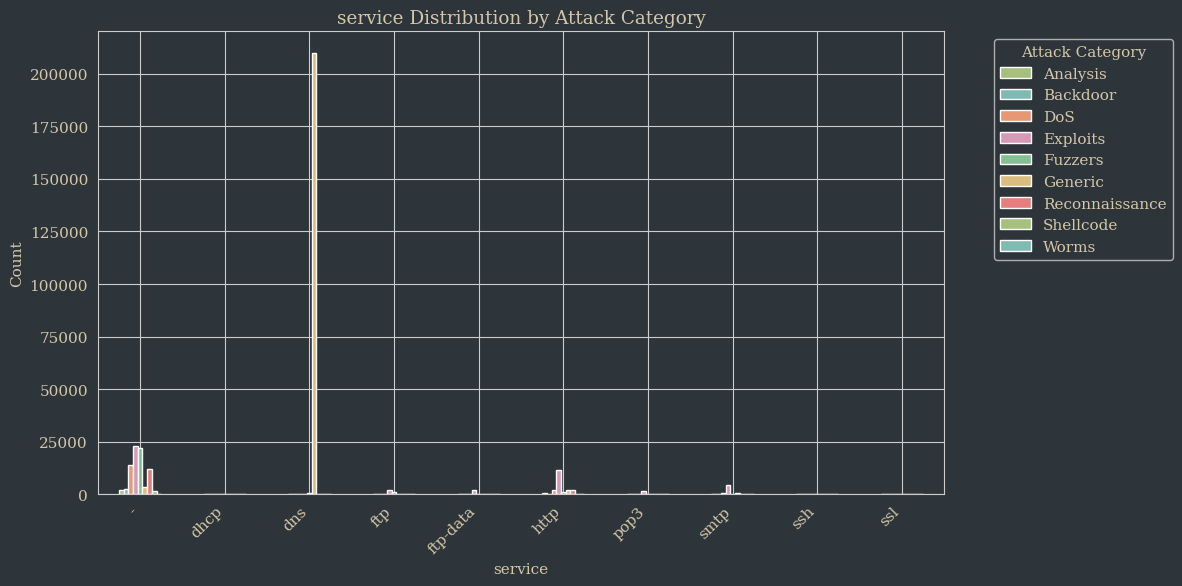

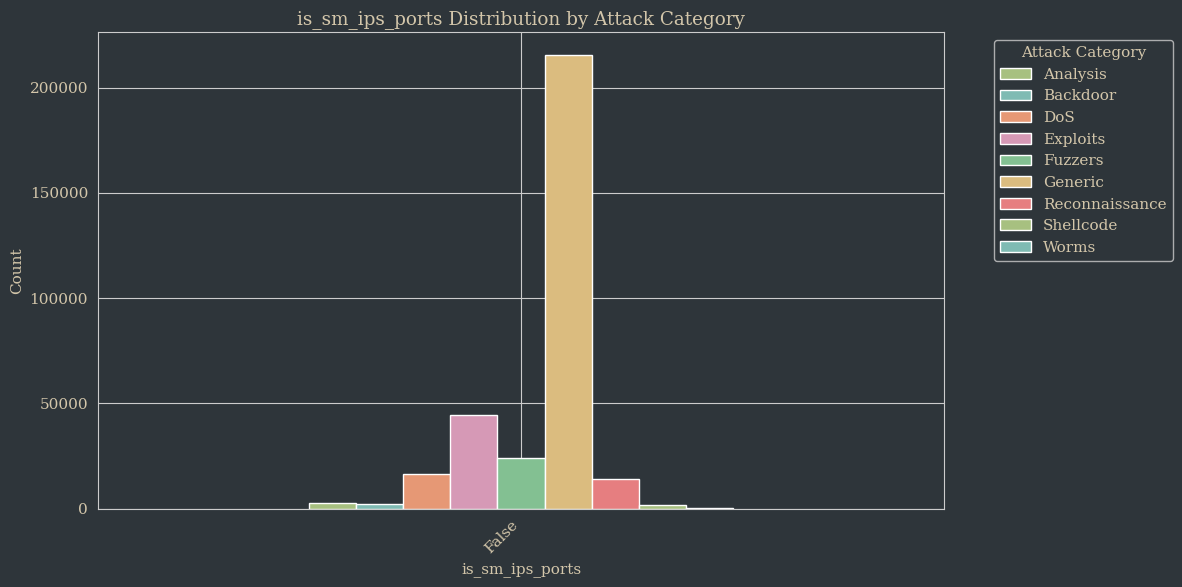

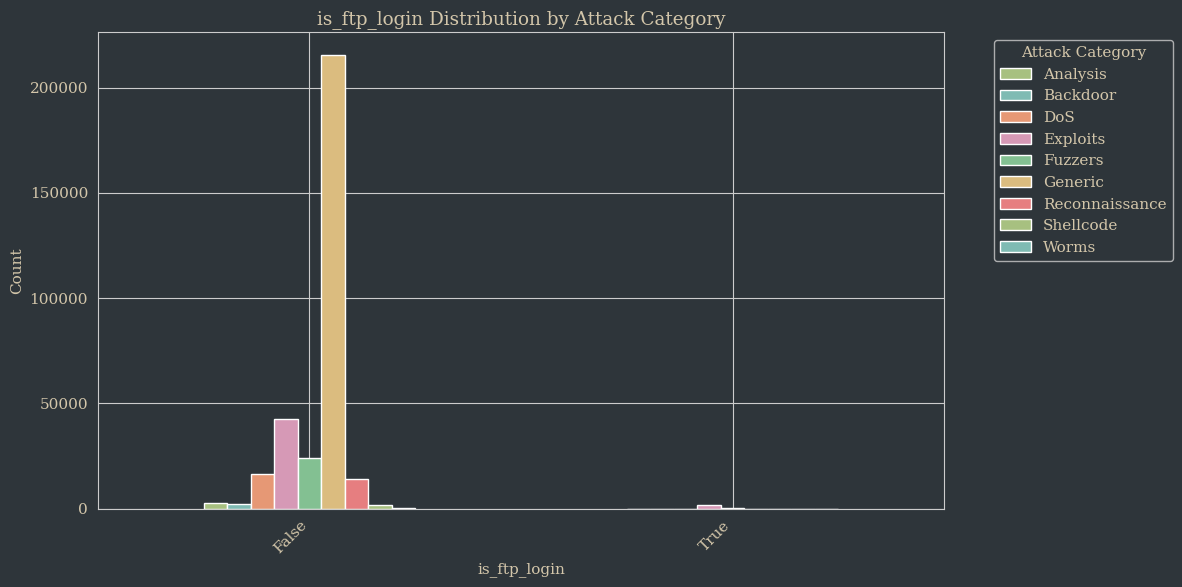

In [21]:
for feature in categorical_features:
    if feature in ['srcip', 'dstip', 'sport', 'dsport']:
        print(f"Skipping {feature} - too high cardinality")
        continue

    if feature in ['is_sm_ips_ports', 'is_ftp_login']:
        cross_tab = pd.crosstab(df[feature], df['attack_cat'])
    else:
        top_values = df[feature].value_counts().head(10).index
        df_filtered = df[df[feature].isin(top_values)]
        cross_tab = pd.crosstab(df_filtered[feature], df_filtered['attack_cat'])

    cross_tab.plot(kind='bar', figsize=(12, 6), stacked=False)
    plt.title(f'{feature} Distribution by Attack Category')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Attack Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Categorical Feature Summary

1. proto: UDP protocol dominates overwhelmingly; TCP and other protocols are rare.
2. state: INT (interrupted) state accounts for vast majority of connections regardless of attack type.
3. service: Most traffic (~210k) has no identified service ("-"), with minimal HTTP, DNS, or other services. This feature may not be very informative.
4. is_sm_ips_ports: Rarely True (matching source/dest IPs and ports), appears slightly more in Generic and Exploits attacks. Could indicate scanning or spoofing behavior when True.
5. is_ftp_login: Almost always False. When True, appears in Exploits and Generic, suggesting FTP-based attacks are uncommon but present.

Categorical features show extreme imbalance and low variance, which may limit their predictive value. These features alone won't distinguish attack types well, numeric features will likely carry more weight in models.


## 2.4 Correlation Analysis

While the target variable for our model is attack category, if we can identify features that are highly correlated with the "Label" feature, that may be useful for feature selection and engineering. We also want to look at the correlations between numeric features to identify any redundant features that could be removed.

In [22]:
label_corr = df[numeric_features + ['Label']].corr()['Label'].sort_values(ascending=False)
print(label_corr)

Label               1.000000
sttl                0.904434
ct_state_ttl        0.873696
ct_dst_src_ltm      0.439925
ct_dst_sport_ltm    0.419063
ct_src_dport_ltm    0.396754
ct_srv_dst          0.386512
ct_srv_src          0.383010
ct_src_ ltm         0.343249
ct_dst_ltm          0.339470
Sload               0.192323
ackdat              0.143398
tcprtt              0.143067
dttl                0.134814
synack              0.122220
ct_flw_http_mthd    0.083185
Sjit                0.020905
ct_ftp_cmd          0.017958
sbytes              0.010178
dur                 0.001944
Dintpkt            -0.010641
Sintpkt            -0.019005
res_bdy_len        -0.027344
trans_depth        -0.029053
sloss              -0.043279
Djit               -0.054558
smeansz            -0.065366
dbytes             -0.075557
dloss              -0.095870
Dpkts              -0.115963
Spkts              -0.120896
Dload              -0.219752
stcpb              -0.233477
dtcpb              -0.233587
dmeansz       

While there is no "magic bullet" feature that perfectly separates attacks from normal traffic, we can identify several features that show some correlations with the "Label" feature (indicating that an attack is present):

* **sttl** (0.90) and **ct_state_ttl** (0.87) are the most positively correlated features with an attack
* **Connection count features** (ct_dst_ltm, ct_srv_dst, etc.) are somewhat correlated
* **Window sizes** (swin, dwin) are negatively correlated, non-attack traffic maintains larger TCP windows
* Many features (sbytes, dur, Sjit) show correlations near zero, but may still be valuable in combination with other features for distinguishing specific attack types.

In [23]:
correlation_matrix = df[numeric_features].corr()

corr_pairs = correlation_matrix.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)
sorted_pairs = sorted_pairs[sorted_pairs < 1]
high_corr = sorted_pairs[sorted_pairs > 0.9]
print(high_corr)

dwin              swin                0.997207
swin              dwin                0.997207
dloss             Dpkts               0.992163
Dpkts             dloss               0.992163
dloss             dbytes              0.991343
dbytes            dloss               0.991343
                  Dpkts               0.970811
Dpkts             dbytes              0.970811
ct_dst_ltm        ct_src_dport_ltm    0.960158
ct_src_dport_ltm  ct_dst_ltm          0.960158
ct_srv_src        ct_srv_dst          0.956730
ct_srv_dst        ct_srv_src          0.956730
sloss             sbytes              0.953495
sbytes            sloss               0.953495
ct_dst_src_ltm    ct_srv_dst          0.951033
ct_srv_dst        ct_dst_src_ltm      0.951033
ct_src_dport_ltm  ct_src_ ltm         0.945338
ct_src_ ltm       ct_src_dport_ltm    0.945338
ct_dst_src_ltm    ct_srv_src          0.942182
ct_srv_src        ct_dst_src_ltm      0.942182
ct_dst_ltm        ct_src_ ltm         0.938520
ct_src_ ltm  

We identified highly correlated feature pairs (correlation > 0.9) and selectively removed 8 features based on both correlation strength and predictive value with the target variable:

* **Window sizes**: Dropped `dwin` (kept `swin`) due to 0.997 correlation
* **Loss metrics**: Dropped `dloss` and `sloss` as they were highly correlated (>0.95) with byte and packet counts
* **Connection count features**: Dropped `ct_srv_src` and `ct_srv_dst` (kept features with higher correlation to "Label", such as `ct_dst_src_ltm` at 0.440)
* **TCP timing**: Dropped `synack` and `ackdat` in favor of `tcprtt`, which represents their sum and shows better correlation with attacks (0.143)
* **State features**: Dropped `ct_state_ttl` (kept `sttl` which has stronger 0.904 correlation with "Label")

In [24]:
features_to_drop = [
    'dwin',
    'dloss',
    'sloss',
    'ct_srv_src',
    'ct_srv_dst',
    'synack',
    'ackdat',
    'ct_state_ttl'
]

df = df.drop(columns=features_to_drop)

# Part 3: Baseline Models

## 3.1 Train/Test Split

We want to remove the "Label" feature from our dataset since it is redundant with "attack_cat" and would not be available in a real-world scenario. We also want to remove the "srcip" and "dstip" features since they are high-cardinality categorical features that would not be useful for modeling. Lastly, we fill in any NA values in the target variable with "Normal" since they represent normal traffic.

In [25]:
X = df.drop(['attack_cat', 'Label', 'srcip', 'dstip'], axis=1)
y = df['attack_cat'].fillna('Normal')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## 3.2 Model Metrics

For this project, we will use the following metrics to evaluate the models:

* **Macro F1**: Treats all attack types equally regardless of frequency, preventing models from ignoring rare but critical attacks like Worms and Shellcode. This is our primary metric for model comparison.

* **Accuracy**: Provides an interpretable "percentage correct" metric that stakeholders easily understand, though this metric is not useful for model comparison due to the class imbalance.

* **Per-class Recall**: Critical for security use cases, where missed attacks (false negatives) are more costly than false alarms. This metric will help us understand which attack types are being detected effectively and which are being missed.

## 3.3 Baseline Model 1: Majority Class (Dummy Classifier)

Possibly the simplest baseline model is to always predict the majority class, which in this case is "Normal" traffic. This will give us a baseline to compare against more complex models. Thus, our "dummy classifier" resulted in 87% accuracy (the proportion of Normal traffic) but 0% recall on all attack types and a macro F1 of 0.093, demonstrating that naive prediction fails completely at the actual task of attack detection. Don't use this model in production!

In [26]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

macro_f1 = f1_score(y_test, y_pred_dummy, average='macro')
print(f"Macro F1 Score for Majority Class Classifier: {macro_f1}")

accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"Accuracy Score for Majority Class Classifier: {accuracy}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_dummy, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")


Macro F1 Score for Majority Class Classifier: 0.0932477904936053
Accuracy Score for Majority Class Classifier: 0.8734975222036931

Per-Class Recall:
  Analysis: 0.0000
  Backdoor: 0.0000
  DoS: 0.0000
  Exploits: 0.0000
  Fuzzers: 0.0000
  Generic: 0.0000
  Normal: 1.0000
  Reconnaissance: 0.0000
  Shellcode: 0.0000
  Worms: 0.0000


## 3.4 Baseline Model 2: Logistic Regression Model

For our logistic regression model, features were imputed (filling missing values with 0 for count-based features like `ct_ftp_cmd` and `ct_flw_http_mthd`) and standardized using StandardScaler, while categorical features were one-hot encoded. We set `class_weight='balanced'` to handle the severe class imbalance and used `max_iter=1000` for convergence.

The model achieved a Macro F1 score of 0.48, representing a 5x improvement over the dummy classifier baseline (0.09), with 96.5% accuracy. Per-class recall showed strong performance on most attack types, particularly Generic (0.97), Shellcode (0.96), and Worms (0.80), though performance was weaker on DoS (0.29) and Backdoor (0.35) attacks.

In [27]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64', 'Int64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns.tolist()

if 'Stime' in numeric_features:
    numeric_features.remove('Stime')
if 'Ltime' in numeric_features:
    numeric_features.remove('Ltime')

X_train_clean = X_train.drop(columns=['Stime', 'Ltime'], errors='ignore')
X_test_clean = X_test.drop(columns=['Stime', 'Ltime'], errors='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ])

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', multi_class='multinomial', random_state=42))
])

pipe_lr.fit(X_train_clean, y_train)
y_pred_lr = pipe_lr.predict(X_test_clean)

macro_f1 = f1_score(y_test, y_pred_lr, average='macro')
print(f"Macro F1 Score for Logistic Regression: {macro_f1}")

accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy Score for Logistic Regression: {accuracy}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")

D:\09 School\DS 7331 - AI1\code\lab_2_classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
D:\09 School\DS 7331 - AI1\code\lab_2_classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Macro F1 Score for Logistic Regression: 0.4821058013109193
Accuracy Score for Logistic Regression: 0.9646749135183132

Per-Class Recall:
  Analysis: 0.3607
  Backdoor: 0.3498
  DoS: 0.2883
  Exploits: 0.4230
  Fuzzers: 0.7232
  Generic: 0.9738
  Normal: 0.9855
  Reconnaissance: 0.6797
  Shellcode: 0.9636
  Worms: 0.8000


# Part 4: Decision Tree, Random Forest, and Gradient Boosting Models

## 4.1 Decision Tree Model

We implemented a Decision Tree classifier using the same preprocessing pipeline as Logistic Regression, with `class_weight='balanced'` to address class imbalance. Decision trees naturally handle both numerical and categorical features without extensive scaling, which is a big advantage with a high-dimensional, mixed dataset like this one.

The Decision Tree achieved strong performance with a Macro F1 score of 0.58
and 97.6% accuracy. The model excelled at detecting Normal traffic (1.00 recall) and Generic attacks (0.99), with strong performance on Reconnaissance (0.76) and Shellcode (0.85). However, it struggled with the rarest attack types, showing weak recall on Analysis (0.15), Backdoor (0.15), DoS (0.23), and Worms (0.43).

In [28]:
pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=1234))
])

pipe_dt.fit(X_train_clean, y_train)
y_pred_dt = pipe_dt.predict(X_test_clean)

macro_f1 = f1_score(y_test, y_pred_dt, average='macro')
print(f"Macro F1 Score for Decision Tree: {macro_f1}")

accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy Score for Decision Tree: {accuracy}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")


Macro F1 Score for Decision Tree: 0.5758893153588829
Accuracy Score for Decision Tree: 0.9754701118896815

Per-Class Recall:
  Analysis: 0.1495
  Backdoor: 0.1459
  DoS: 0.2296
  Exploits: 0.5416
  Fuzzers: 0.5515
  Generic: 0.9873
  Normal: 0.9965
  Reconnaissance: 0.7605
  Shellcode: 0.8510
  Worms: 0.4286


## 4.2 Random Forest Model

We implemented a Random Forest classifier with 100 trees, and with `class_weight='balanced'` for imbalance handling and `n_jobs=-1` for parallel processing (to speed things up a bit, since RF can be computationally intensive).

The model achieved the best performance with a Macro F1 score of 0.58 and 97.9% accuracy, representing modest improvements over the single Decision Tree. Notable improvements included DoS detection (0.44 vs 0.23), Exploits (0.59 vs 0.54), and Shellcode (0.86 vs 0.85). However, the ensemble approach did not improve performance on the rarest attack types, with Analysis (0.14), Backdoor (0.11), and Worms (0.23) showing lower recall than some previous models.

In [29]:
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        n_jobs=-1,
        random_state=1234
    ))
])

pipe_rf.fit(X_train_clean, y_train)
y_pred_rf = pipe_rf.predict(X_test_clean)

macro_f1 = f1_score(y_test, y_pred_rf, average='macro')
print(f"Macro F1 Score for Random Forest: {macro_f1}")

accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy Score for Random Forest: {accuracy}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")


Macro F1 Score for Random Forest: 0.5806376381139248
Accuracy Score for Random Forest: 0.9785966439002108

Per-Class Recall:
  Analysis: 0.1364
  Backdoor: 0.1073
  DoS: 0.4356
  Exploits: 0.5869
  Fuzzers: 0.5335
  Generic: 0.9862
  Normal: 0.9980
  Reconnaissance: 0.7597
  Shellcode: 0.8609
  Worms: 0.2286


## 4.3 Gradient Boosting Model

We implemented XGBoost as a faster alternative to sklearn's GradientBoostingClassifier, which failed to finish after 7+ hours, and which is the reason this project is late! XGBoost leverages parallelization and is more efficient in memory usage. We encoded categorical labels numerically (required by XGBoost) and used `tree_method='hist'` for additional speed optimization with `n_estimators=100`.

XGBoost achieved competitive performance with a Macro F1 of 0.58 and the highest accuracy at 98.1%. The model showed very good performance on Exploits (0.93 recall), significantly outperforming all other models on this class. It also excelled on Shellcode (0.91) and Reconnaissance (0.78). However, XGBoost exhibited the most polarized performance profile, with severe weaknesses on the rarest attack types: Analysis (0.05), Backdoor (0.07), and DoS (0.04). This suggests the model is optimized for frequent classes at the expense of rare ones.


In [30]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        n_jobs=-1,
        random_state=1234,
        tree_method='hist'
    ))
])

pipe_xgb.fit(X_train_clean, y_train_encoded)
y_pred_xgb = pipe_xgb.predict(X_test_clean)
y_pred_xgb_decoded = le.inverse_transform(y_pred_xgb)

macro_f1 = f1_score(y_test, y_pred_xgb_decoded, average='macro')
print(f"Macro F1 Score for XGBoost: {macro_f1:.4f}")

accuracy = accuracy_score(y_test, y_pred_xgb_decoded)
print(f"Accuracy Score for XGBoost: {accuracy:.4f}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_xgb_decoded, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")

Macro F1 Score for XGBoost: 0.5799
Accuracy Score for XGBoost: 0.9811

Per-Class Recall:
  Analysis: 0.0542
  Backdoor: 0.0687
  DoS: 0.0431
  Exploits: 0.9337
  Fuzzers: 0.4193
  Generic: 0.9842
  Normal: 0.9983
  Reconnaissance: 0.7783
  Shellcode: 0.9073
  Worms: 0.4857


# Part 5: Hyperparameter Search

## 5.1 Decision Tree Hyperparameter Tuning

We used RandomizedSearchCV with 3-fold stratified cross-validation to tune four key hyperparameters: `max_depth` (10, 20, 30, None), `min_samples_split` (2, 5, 10, 20), `min_samples_leaf` (1, 2, 4), and `criterion` ('gini', 'entropy'). To reduce computational cost, we sampled 500k rows for the search phase then retrained the best model on the full dataset.

The search identified optimal parameters of max_depth=30, min_samples_split=5, min_samples_leaf=1, and criterion='entropy', achieving a CV Macro F1 of 0.5909 (±0.0115). The tuned model improved test performance by 4.3% (0.5759 → 0.6007), with notable gains on rare attack classes including Backdoor (0.15 → 0.22), DoS (0.23 → 0.37), and Worms (0.43 → 0.57). The deeper trees (max_depth=30) with entropy criterion allowed the model to capture more complex patterns in the imbalanced network traffic data.


In [31]:
X_train_sample, y_train_sample = resample(
    X_train_clean, y_train,
    n_samples=500000,
    stratify=y_train,
    random_state=1234
)

param_grid_dt = {
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

pipe_dt_base = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

search_dt = RandomizedSearchCV(
    pipe_dt_base,
    param_grid_dt,
    n_iter=6,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

search_dt.fit(X_train_sample, y_train_sample)

best_dt = search_dt.best_estimator_
best_dt.fit(X_train_clean, y_train)
y_pred_dt_tuned = best_dt.predict(X_test_clean)

macro_f1 = f1_score(y_test, y_pred_dt_tuned, average='macro')
print(f"Macro F1 Score for Decision Tree (Tuned): {macro_f1:.4f}")

accuracy = accuracy_score(y_test, y_pred_dt_tuned)
print(f"Accuracy Score for Decision Tree (Tuned): {accuracy:.4f}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_dt_tuned, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")

print(f"\nBest Parameters: {search_dt.best_params_}")
print(f"CV Macro F1: {search_dt.best_score_:.4f} ± {search_dt.cv_results_['std_test_score'][search_dt.best_index_]:.4f}")

Macro F1 Score for Decision Tree (Tuned): 0.6007
Accuracy Score for Decision Tree (Tuned): 0.9743

Per-Class Recall:
  Analysis: 0.1645
  Backdoor: 0.2210
  DoS: 0.3650
  Exploits: 0.5458
  Fuzzers: 0.7199
  Generic: 0.9872
  Normal: 0.9921
  Reconnaissance: 0.7637
  Shellcode: 0.8808
  Worms: 0.5714

Best Parameters: {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30, 'classifier__criterion': 'entropy'}
CV Macro F1: 0.5909 ± 0.0115


## 5.2 Random Forest Hyperparameter Tuning

We applied the same RandomizedSearchCV approach to Random Forest, tuning `n_estimators` (50, 100, 150), `max_depth` (20, 30, None), `min_samples_split` (2, 5, 10), and `min_samples_leaf` (1, 2). The search identified n_estimators=150, max_depth=20, min_samples_split=5, and min_samples_leaf=1 as optimal, with CV Macro F1 of 0.5957 (±0.0224).

The tuned model achieved 4.6% improvement (0.5806 → 0.6075) and the highest overall Macro F1 score among all models. Tuning delivered exceptional improvements on challenging classes: DoS recall increased from 0.44 to 0.58, Fuzzers from 0.53 to 0.88, and Analysis from 0.14 to 0.27. The optimal configuration of 150 trees with moderate depth (20) balanced model bias and variance, proving most effective at handling the severe class imbalance while maintaining strong performance across all attack categories.

In [32]:
X_train_sample, y_train_sample = resample(
    X_train_clean, y_train,
    n_samples=500000,
    stratify=y_train,
    random_state=1234
)

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2]
}

pipe_rf_base = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42))
])

search_rf = RandomizedSearchCV(
    pipe_rf_base,
    param_grid_rf,
    n_iter=6,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42
)

search_rf.fit(X_train_sample, y_train_sample)

best_rf = search_rf.best_estimator_
best_rf.fit(X_train_clean, y_train)
y_pred_rf_tuned = best_rf.predict(X_test_clean)

macro_f1 = f1_score(y_test, y_pred_rf_tuned, average='macro')
print(f"Macro F1 Score for Random Forest (Tuned): {macro_f1:.4f}")

accuracy = accuracy_score(y_test, y_pred_rf_tuned)
print(f"Accuracy Score for Random Forest (Tuned): {accuracy:.4f}")

print("\nPer-Class Recall:")
report = classification_report(y_test, y_pred_rf_tuned, output_dict=True, zero_division=0)
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        print(f"  {class_name}: {metrics['recall']:.4f}")

print(f"\nBest Parameters: {search_rf.best_params_}")
print(f"CV Macro F1: {search_rf.best_score_:.4f} ± {search_rf.cv_results_['std_test_score'][search_rf.best_index_]:.4f}")

Macro F1 Score for Random Forest (Tuned): 0.6075
Accuracy Score for Random Forest (Tuned): 0.9721

Per-Class Recall:
  Analysis: 0.2748
  Backdoor: 0.1373
  DoS: 0.5766
  Exploits: 0.5561
  Fuzzers: 0.8771
  Generic: 0.9786
  Normal: 0.9864
  Reconnaissance: 0.8173
  Shellcode: 0.9702
  Worms: 0.5429

Best Parameters: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}
CV Macro F1: 0.5957 ± 0.0224


# Part 6: Final Model Comparison

## Overall Metrics

| Model | Macro F1 | Accuracy |
|-------|----------|----------|
| Dummy Classifier (Baseline A) | 0.0932 | 0.8735 |
| Logistic Regression (Baseline B) | 0.4821 | 0.9647 |
| Decision Tree (Tuned) | 0.6007 | 0.9743 |
| Random Forest (Tuned) | 0.6075 | 0.9721 |
| XGBoost | 0.5799 | 0.9811 |

As expected, models substantially outperformed the dummy baseline (Macro F1: 0.093).

Logistic Regression established a solid baseline with Macro F1 of 0.48 and 96.5% accuracy, representing a 5x improvement over random guessing.

Tree-based models significantly outperformed the linear baseline, with tuned Decision Tree (0.60 F1) and Random Forest (0.61 F1) achieving 25% and 26% improvements respectively. Random Forest (Tuned) achieved the highest Macro F1 score of 0.6075, while XGBoost attained the highest raw accuracy at 98.1% despite a lower Macro F1 of 0.58.

Hyperparameter tuning improved both Decision Tree and Random Forest by approximately 4-5%. The high accuracy across all models (>96%) reflects the dataset's 87% normal traffic baseline, which confirms that Macro F1 is the more meaningful metric for this imbalanced dataset.

## Per-Class Recall

| Attack Category | Dummy | Logistic Regression | Decision Tree (Tuned) | Random Forest (Tuned) | XGBoost |
|-----------------|-------|---------------------|----------------------|----------------------|---------|
| Analysis | 0.0000 | 0.3607 | 0.1645 | 0.2748 | 0.0542 |
| Backdoor | 0.0000 | 0.3498 | 0.2210 | 0.1373 | 0.0687 |
| DoS | 0.0000 | 0.2883 | 0.3650 | 0.5766 | 0.0431 |
| Exploits | 0.0000 | 0.4230 | 0.5458 | 0.5561 | 0.9337 |
| Fuzzers | 0.0000 | 0.7232 | 0.7199 | 0.8771 | 0.4193 |
| Generic | 0.0000 | 0.9738 | 0.9872 | 0.9786 | 0.9842 |
| Normal | 1.0000 | 0.9855 | 0.9921 | 0.9864 | 0.9983 |
| Reconnaissance | 0.0000 | 0.6797 | 0.7637 | 0.8173 | 0.7783 |
| Shellcode | 0.0000 | 0.9636 | 0.8808 | 0.9702 | 0.9073 |
| Worms | 0.0000 | 0.8000 | 0.5714 | 0.5429 | 0.4857 |

Model performance varied dramatically across attack categories.

All models showed excellent detection of Generic attacks (0.97-0.99 recall) and Normal traffic (0.99-1.00 recall), the two most frequent classes.

Rare classes (like Analysis, Backdoor, and DoS) are where most models struggled with recall below 0.30.

Random Forest (with tuned hyperparameters) demonstrated the most balanced performance profile, achieving strong recall across diverse attack types.

Decision Tree (tuned) showed consistent mid-to-high performance across categories with fewer extreme weaknesses.

XGBoost exhibited the most polarized behavior: it was exceptional on Exploits (0.93 recall, 38% higher than RF) but severely deficient on rare classes like Analysis (0.05), Backdoor (0.07), and DoS (0.04).

Logistic Regression, despite lower overall Macro F1, achieved the highest Worms detection (0.80) and competitive Fuzzers performance (0.72).

All models struggled with Analysis and Backdoor attacks (<0.28 recall), suggesting that these rare attack types might benefit from additional research and/or feature engineering.